# Dynamic Programming and Structural Econometrics #5

### Function approximation and interpolation

**Readings:** 
- 📖 Judd, K. L. (1998). Numerical methods in economics. MIT press. Section 6
- 📖 Jerome Adda and Russell Cooper “Dynamic Economics. Quantitative Methods and Applications.” Sections 3.5 

by Bertel Schjerning

University of Copenhagen


### Agenda
- **The Approximation Problem**
    - How to approximate a function $ f(x) $ given data at $ n $ points  
      $ (x_1, \dots, x_n) $  
- **Sieve Approximation (Using Linear Regression)**
    - Examples: Polynomials, Splines
    - Approximation properties depend crucially on the support of basis functions  
    - Splines have **bounded support** $ \Rightarrow $ local approximation  
    - Polynomials have **unbounded support** $ \Rightarrow $ global approximation  
- **Orthogonal Polynomials**
    - Key example: **Chebyshev polynomials**  
    - Optimal nodes: **Chebyshev zeros** $ \Rightarrow $ minimizes the maximum error bound (min-max property)  
    - Excellent for approximating smooth functions but struggles with **kinks**.  
- **Multivariate Extensions**
    - **1D sieve methods** generalize to **$ d $-dimensions** using a tensor-product basis and a Cartesian grid  
    - **Curse of Dimensionality**  
    - Possible solutions: **Sparse grids, Machine Learning (Lasso, Neural Nets, etc.)**  

### Approximation problem

- $ f(x) $ is the function of interest but is **hard to compute**  
- We have data on values of $ f(x) $ at **$ n $ points**:  $ (x_1, x_2, \dots, x_n) $

$$
f(x_1), f(x_2), \dots, f(x_n)
$$

- Goal: Find an **approximate value** $ \hat{f}(x) $ of the function $ f(x) $  
  for arbitrary points $ x \in [a, b] $  

- **Extrapolation is needed** if $ x $ is outside the observed range $a<x_1$ or $b>x_n$  

### Before we move on we need some standard libraries, tools for sieve interpolation, tools for potting etc. 

In [1]:
# Load standard libraries for function approximation and interpolation
import numpy as np              # Numerical computing
import numpy.linalg as la       # Linear algebra functions
from lib.sieve import *         # Custom sieve library for function approximation
import matplotlib.pyplot as plt # Plotting utilities
from scipy import interpolate   # Interpolation routines
from numpy.polynomial import polynomial # Polynomial fitting and evaluation

# Enable inline plotting and set default font size
%matplotlib inline
plt.rcParams.update({'font.size': 16})

# Enable automatic module reloading for development
%load_ext autoreload
%autoreload 2

### Example: Linear interpolation
- Consider the function 
  $$
  f(x) = \exp(-x/4) \sin(x) + \frac{1}{1+x^2}
  $$
- Goal: Approximate $ f(x) $ for any $ x \in [a, b] $
- We have observations of $ f(x) $ at $ m $ grid points $ x^g = (x_1, \dots, x_m) $<br>
- Experiments: 
    - Try changing **m** (more points → better accuracy?).  
    - Adjust **a and b** to see how the interpolation behaves over different intervals.
    - Test **extrapolation**—does it behave as expected outside the observed range?

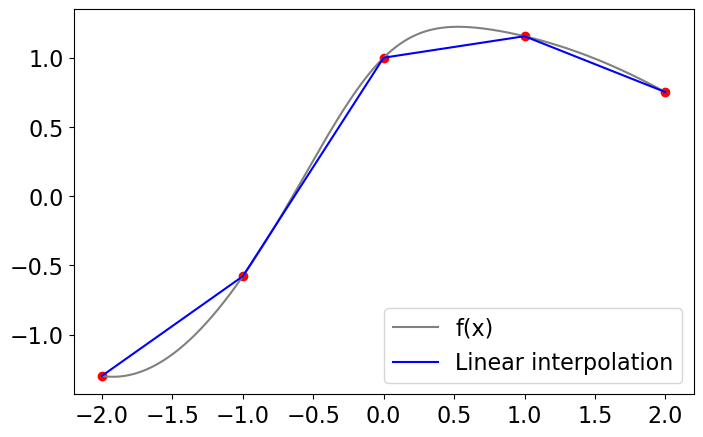

In [2]:
f = lambda x: np.exp(-x/4) * np.sin(x) + 1/(1 + x**2)  # Function to interpolate/approximate
m, a, b = 5, -2, 2                                     # TRY changing data points (m) and interval [a, b]
x_g = np.linspace(a, b, m)                             # Grid points where we know f(x)
fx_g = f(x_g)                                          # Observed function values at grid pints
fhat = interpolate.interp1d(x_g, fx_g, kind='linear')  # Linear interpolation
extrapolate = 0                                        # TRY eExtrapolation if >0
x = np.linspace(a - extrapolate, b + extrapolate, 100) # (extended) evaluation grid
fhat_lin = interpolate.interp1d(x_g, fx_g, bounds_error=False, fill_value='extrapolate')  
plot1d(None, x_g, fx_g) # (plotting tool in sieve.py)
plot1d(f, x, None, fhat_lin, label='Linear interpolation')

### Observations from the linear interpolation example
- **Linear interpolation** is a simple and widely used method (connect the dots).  
- It is **non-differentiable** at grid points.  
- **Underestimates in concave regions** (overestimates in convex).  
- **Fails to capture oscillations**, especially when the function is highly nonlinear.  
- **More points $ m $ improves accuracy**, but remains piecewise linear.  
- **Works best well-sampled data**, but struggles with steep drops and rapid changes.  
- **Extrapolation flattens out**, leading to poor predictions outside the observed range. 

Can we find a **better approximation** $\hat{f}(x)$?

### Approaches to Function Approximation  
We can approximate $ f(x) $ using **global**, **local**, or **hybrid** methods:  

1. **Global Approximation (Single Function on Entire Interval)**  
   - Uses one function to fit all data (e.g., **polynomials, Chebyshev**).  
   - Captures global patterns but struggles with local details.  
   - All coefficients depend on all data points 
   - numerical instability in high-degree polynomials.  
2. **Local Approximation (Piecewise Methods)**  
   - Approximates $ f(x) $ **locally**, with basis functions that have **bounded support**.  
   - Examples: **Linear interpolation, B-splines, kernel methods**.  
   - Robust to local irregularities, but may require many parameters for smoothness.  

3. **Hybrid Approaches (Combining Local & Global Features)**  
   - Balances **local control** with **global smoothness** (e.g., **B-splines, sieves**).  
   - **Higher-order splines** use multiple grid points to smooth transitions.  

**Key insight**: Basis function **support** determines whether a method is **global, local, or hybrid**.  

### Comparing Linear and Polynomial Interpolation  
- **Linear interpolation** is piecewise and local, connecting grid points directly.  
- **Polynomial interpolation** fits a single polynomial to all points (global).  
- **Experiments:**  
  - Try changing **m** to observe accuracy improvements and oscillations.  
  - Adjust **m** to see how both methods behave with more/fewer points.  
  - Set **extrapolate > 0** to test behavior outside the observed range.  
  - Change degree of polynomial (degree $m-1$ for interpolation)

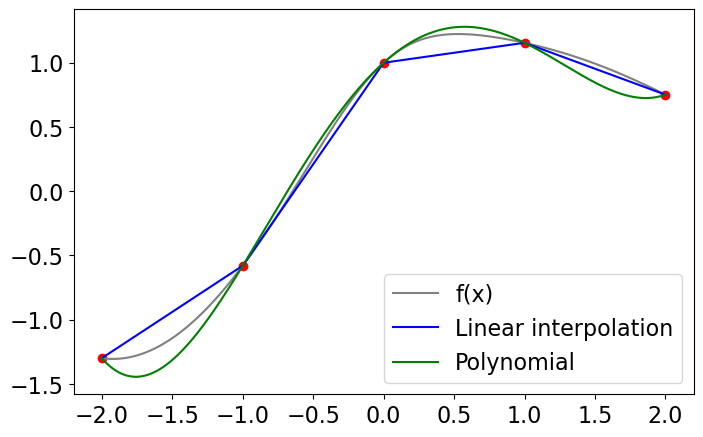

In [3]:
m, a, b = 5, -2, 2                                     # TRY chaning data points (m) and interval [a, b]
x_g = np.linspace(a, b, m)                              # Grid points where we know f(x)
fx_g = f(x_g)                                           # Function values at grid pints
fhat_lin = interpolate.interp1d(x_g, fx_g, bounds_error=False, fill_value='extrapolate')  
deg = m-1                                              # TRY chaning degree of approximating polynomial
polcoef = polynomial.polyfit(x_g,fx_g,deg)              # polynomial interpolation coefficients
fhat_pol = lambda x: polynomial.polyval(x,polcoef)
extrapolate = 0                                         # TRY Extrapolation if >0
x = np.linspace(a - extrapolate, b + extrapolate, 100)  # (extended) evaluation grid
plot1d(None, x_g, fx_g) # (plotting tool in sieve.py)
plot1d(f, x, None, fhat_lin, label='Linear interpolation')
plot1d(None, x, None, fhat_pol, label='Polynomial', color='g') # use the the plotting tool

### Observations: Linear vs. Polynomial Interpolation  
- **Local vs. Global**:  
  - Linear interpolation is **local**, connecting grid points directly.  
  - Polynomial interpolation is **global**, fitting a single function to all points.  
- **Trade-offs**:  
  - Linear interpolation is **stable but non-smooth** (piecewise linear).  
  - Higher-degree polynomials improve smoothness but risk **Runge’s phenomenon** (edge oscillations) and **sensitivity** (one point changes the entire fit).  
- **Extrapolation fails**:  
  - Linear interpolation **flattens** beyond known data.  
  - Polynomial interpolation can **diverge unpredictably**.  

**Can we design better approximation methods?**  
**How does the choice of basis functions affect results?**

## Sieve Approximation  
- **Local piecewise approach**: Approximate $f(x)$ using stepwise constant functions.  
  - Divide $[a,b]$ into $n+1$ subintervals $[x_j, x_{j+1}]$.  
  - Approximate $f(x)$ as:  
    $$
    f(x) \approx \sum_{j=0}^{n} \alpha_j \mathbb{1}(x_j\le x < x_{j+1})
    $$

- **Smooth global approach**: Approximate $f(x)$ using polynomials.  
  - Fit a degree-$n$ polynomial:  
        $$f(x) \approx p_n(x,\alpha)=\alpha_0 + \alpha_1 x + \alpha_2 x^2 \dots + \alpha_n x^n = \sum_{j=0}^n \alpha_j x^j $$

- **Linear sieves** unify both approaches:  
  - Approximate $f(x)$ using $n+1$ parameters and basis functions $\{B_j(x)\}$:  
    $$
    f(x) \approx s(x,\alpha) = \sum_{j=0}^{n} \alpha_j B_j(x)
    $$
  - Examples of basis functions:
    - **Step function**: $B_j(x) = \mathbb{1}(x_j\le x < x_{j+1})$  
    - **Algebraic polynomial basis**: $B_j(x) = x^j$  
  - The choice of basis functions determines the approximation’s accuracy, smoothness, and stability.

### Approximating $f(x)$ using a sieve $s(x, \alpha)$  
- **Given:**
    - A **dataset**: $ \{(x_i, f(x_i))\}, i=1, \dots, m $  
    - A set of **$ n+1 $ known basis functions** $ \{ B_j(x) \}_{j=0}^{n} $, e.g., **$ B_j(x) = x^j $** for polynomials  
- **Goal:**  
    - Approximate $ f(x) $ using a linear sieve  
    - Estimate parameters **$ \alpha = (\alpha_0, \dots, \alpha_n) $**  
- **Solution:**  
    - **Linear regression** on $ m \geq n+1 $ grid points  
    $$
    \hat{\alpha} = \arg \min_{\alpha \in \mathbb{R}^{n+1}} \sum_{i=1}^{m} \left[ f(x_i) - \sum_{j=0}^{n} \alpha_j B_j(x_i) \right]^2
    $$
    - This minimizes the squared error between the function values and the sieve approximation.  

### Can we approximate $f(x)$?

Can we determine the coefficients $ \alpha $?  
- **Yes**, if we have at least $ m \geq n+1 $ data points.  
- The grid points $ x_i $ must be distinct and the basis functions $ B_j(x) $ must not be collinear.  
- Then, all $ n+1 $ coefficients in $ \alpha $ are **uniquely identified**.  
- **OLS solution**:  
  $$
  \alpha = \left(B(x)'B(x)\right)^{-1} B(x)' f(x)
  $$

Can we handle high-order polynomials when $ x $ is large?  
- **Yes**, by transforming $ x \in [a, b] $ to a standardized domain $ z \in [-1,1] $.  
- This avoids numerical instability in polynomial approximation.  

Can we approximate $ f(x) $?  
- **Yes**, at least at the known grid points (**exactly if** $ m = n+1 $).  
- Before analyzing theoretical properties, **let’s see how well it works in practice!**

In [4]:
## f = lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)  # Function to approximate
m, deg, a, b = 5, 4, -1, 2                            # TRY changing m (datapoints), deg (degree), and interval [a, b]

s1 = sieve(m, deg, a, b, btype='algpol', gridtype='u') # TRY polynomial with uniform grid
#s1 = sieve(m, deg, a, b, btype='chebyshev', gridtype='c') # TRY Chebyshev polynomials (orthogonal basis)
#s1 = sieve(m, deg, a, b, btype='b-spline', gridtype='u') # TRY B-splines (use m=5, deg=1, 2, 3 and x0 and grid)

x0, z0, fx0 = s1.x, s1.z, f(s1.x)                      # Grid points and function values
B = sieve.basis(x0, s1.deg, s1.btype, s1.knotsx)       # Basis matrix (TRY both x0 and z0 for algebraic polynomials - does not work for cheb. and spines)
pB = la.inv(B.T@B)@B.T                                 # Projection matrix for sieve space
α = pB @ fx0                                           # OLS regression of f(x) on basis functions

np.set_printoptions(suppress=True, formatter={'float': '{: 10.3f}'.format})
print('z0.T ', z0.T, '\nx0.T ', x0.T, '\nfx0.T', fx0.T, '\nB\n', B, '\n(B.T@B)\n', B.T@B,
      '\nα=inv(B.T@B)@B.T@fx0\n', α, '\nfhat=B.T@α (Transposed)\n', (B@α).T, '\nfx0-fhat (Transposed)\n', (fx0-B@α).T)
np.set_printoptions()

z0.T  [[    -1.000     -0.500      0.000      0.500      1.000]] 
x0.T  [[    -1.000     -0.250      0.500      1.250      2.000]] 
fx0.T [[    -0.580      0.678      1.223      1.085      0.752]] 
B
 [[     1.000     -1.000      1.000     -1.000      1.000]
 [     1.000     -0.250      0.062     -0.016      0.004]
 [     1.000      0.500      0.250      0.125      0.062]
 [     1.000      1.250      1.562      1.953      2.441]
 [     1.000      2.000      4.000      8.000     16.000]] 
(B.T@B)
 [[     5.000      2.500      6.875      9.062     19.508]
 [     2.500      6.875      9.062     19.508     34.082]
 [     6.875      9.062     19.508     34.082     68.831]
 [     9.062     19.508     34.082     68.831    131.776]
 [    19.508     34.082     68.831    131.776    262.964]] 
α=inv(B.T@B)@B.T@fx0
 [[     0.947]
 [     0.902]
 [    -0.705]
 [    -0.019]
 [     0.061]] 
fhat=B.T@α (Transposed)
 [[    -0.580      0.678      1.223      1.085      0.752]] 
fx0-fhat (Transposed)
 [[  

### Distinction for function approximation: interpolation and curve fitting

- **Interpolation** refers to the situations when **data** on function values is matched **exactly**  
  - The approximation curve passes through the points of the data
  - If parameters of approximating function is "estimated" parameters are *exactly-identified* 
- **Curve fitting** refers to the statistical problem when the data has
  **noise**, the task is to find an approximation for the central
  tendency in the data  
  - Linear and non-linear regression models, econometrics  
  - The model is *over-identified* (there is more data than needed to
    exactly identify the regression function) 
  - For approximations of functions, there is not really noise in our data. However, when the basis does not span the full functional space that $f(x)$ belongs to we will not be able to match all the points and we use ideas similar curve fitting (often linear regression).

### Does sieve $s(x;\alpha)$ converge to $f(x)$ when there are more points and/or basis functions?
- This depends on the function and the choice of basis functions. Let's first focus on polynomials!

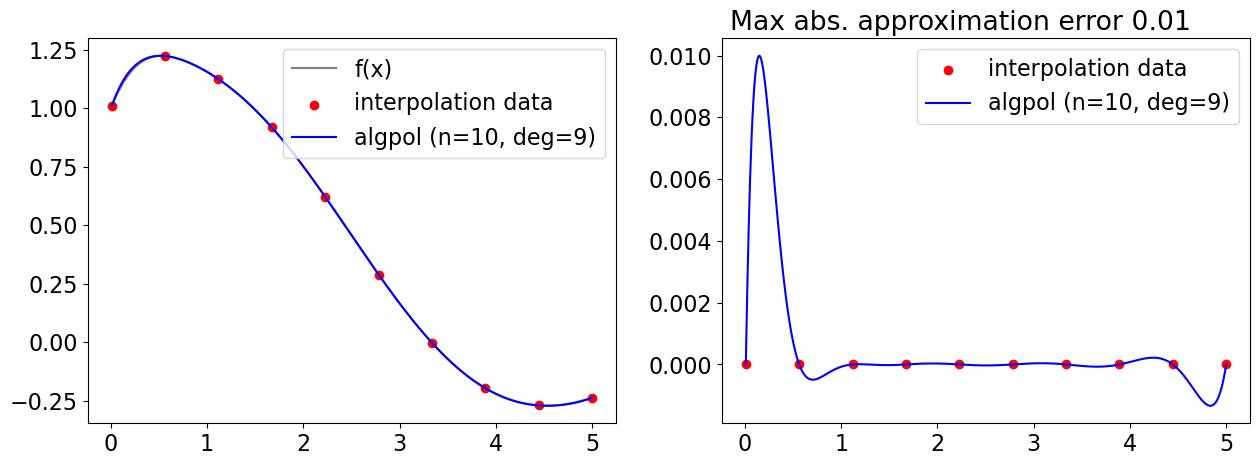

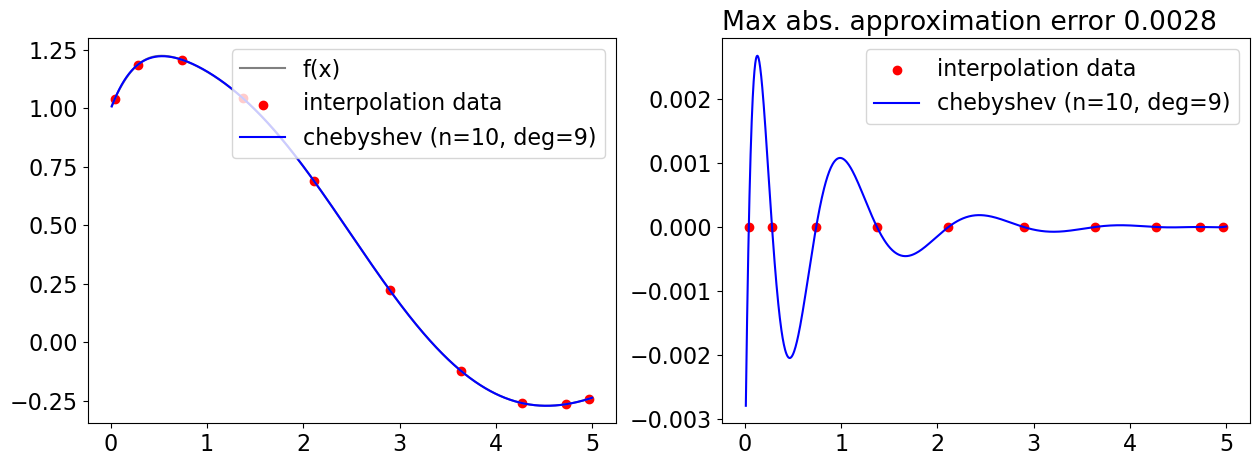

In [5]:
f= lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)    # function to interpolate/approximate
# f = lambda x: (np.log(x*2/3)+0.5*np.log(x*1/3))    # another function to approximate (only for x>0)
a=0.01; b=5; n=10; deg=n-1;
sa=sieve(n, deg, a, b, btype='algpol', gridtype='u');    sa.plot1d(f); plt.show() # basis: (ordinary) Algrbraic polynomials
sc=sieve(n, deg, a, b, btype='chebyshev', gridtype='c'); sc.plot1d(f); plt.show() # basis: Chebyshev polynomials

### Least squares approximation

We could also go back to **function approximation** and fit polynomials
of lower degree

- Data set $ \{(x_i,f(x_i)\}, i=1,\dots,m $  
- **Any** functional form $ g(x) $ from class $ G $ that best
  approximates $ f(x) $  


$$
g = \arg\min_{g \in G} \lVert f-g \rVert ^2
$$

### Orthogonal polynomial approximation/interpolation

- Polynomials over domain $ D $  
- Weighting function $ w(x)>0 $  


Inner product

$$
\langle f,g \rangle = \int_D f(x)g(x)w(x)dx
$$

$ \{\phi_i\} $ is a family of orthogonal polynomials w.r.t.
$ w(x) $ iff

$$
\langle \phi_i,\phi_j \rangle = 0, i\ne j
$$

#### Best polynomial approximation in L2-norm

Let $ \mathcal{P}_n $ denote the space of all polynomials of degree $ n $ over $ D $

$$
\lVert f - p \rVert_2 = \inf_{q \in \mathcal{P}_n} \lVert f - q \rVert_2
= \inf_{q \in \mathcal{P}_n}  \left[ \int_D ( f(x)-q(x) )^2 dx  \right]^{\tfrac{1}{2}}
$$

if and only if

$$
\langle f-p,q \rangle = 0, \text{ for all } q \in \mathcal{P}_n
$$

*Orthogonal projection is the best approximating polynomial in L2-norm*

#### Uniform (infinity, sup-) norm

$$
\lVert f(x) - g(x) \rVert_{\infty} = \sup_{x \in D} | f(x) - g(x) |
= \lim_{n \rightarrow \infty} \left[ \int_D ( f(x)-g(x) )^n dx  \right]^{\tfrac{1}{n}}
$$

Measures the maximum absolute difference over the whole domain $ D $

#### Chebyshev (minmax) approximation

What is the best polynomial approximation in the uniform (infinity, sup) norm?

$$
\lVert f - p \rVert_{\infty} = \inf_{q \in \mathcal{P}_n} \lVert f - q \rVert_{\infty}
= \inf_{q \in \mathcal{P}_n}  \sup_{x \in D} | f(x) - g(x) |
$$

Chebyshev proved existence and uniqueness of the best approximating polynomial in uniform norm.

### Least Squares Approximation

#### **Key Idea**  
- Instead of exact interpolation, we seek an **approximate fit** for $ f(x) $ using a lower-degree polynomial.
- This is useful when the number of data points **$ m > n+1 $**, making exact interpolation impossible.

#### **Mathematical Formulation**  
- Given a dataset **$ \{(x_i, f(x_i)\}, i=1,\dots,m $**, find a function **$ g(x) $** in a class **$ G $** that minimizes the error:

  $$
  g^* = \arg\min_{g \in G} \lVert f - g \rVert^2
  $$  

- The best approximation minimizes the squared difference between **$ f(x) $** and **$ g(x) $** over all data points.

#### **Why Least Squares?**
- Works well when data is noisy or when an exact polynomial fit would lead to **overfitting**.
- Reduces sensitivity to extreme values at the endpoints.
- Forms the basis for **orthogonal polynomial approximation**, leading to better numerical stability.

### Orthogonal Polynomial Approximation

#### **Key Idea**  
- Instead of using arbitrary polynomials, we use **orthogonal polynomials**, which provide more stable and well-conditioned approximations.

#### **Inner Product & Orthogonality**  
- Define an **inner product** for two functions **$ f(x) $** and **$ g(x) $**:

  $$
  \langle f,g \rangle = \int_D f(x) g(x) w(x) dx
  $$  

- A set of polynomials **$ \{\phi_i(x)\} $** is **orthogonal** w.r.t. weight function **$ w(x) $** if:

  $$
  \langle \phi_i, \phi_j \rangle = 0, \quad i \neq j
  $$  

#### **Why Use Orthogonal Polynomials?**
- They minimize **correlation** between basis functions, making them numerically stable.
- Useful in least squares approximation, reducing the risk of **ill-conditioned** polynomial fits.
- Common examples: **Legendre polynomials, Chebyshev polynomials, Laguerre polynomials.**

### Best Polynomial Approximation in L2-Norm  

#### **Key Idea**  
- We want to approximate **$ f(x) $** using a polynomial **$ p(x) $** of degree **$ n $** that minimizes the squared error over the domain **$ D $**.  
- The best polynomial **$ p(x) $** is the **L2 projection** of **$ f(x) $** onto the space of polynomials **$ \mathcal{P}_n $**.

#### **Mathematical Formulation**  
- The best approximation minimizes the **L2 error**:

  $$
  \lVert f - p \rVert_2 = \inf_{q \in \mathcal{P}_n} \lVert f - q \rVert_2
  = \inf_{q \in \mathcal{P}_n}  \left[ \int_D ( f(x)-q(x) )^2 dx  \right]^{\tfrac{1}{2}}
  $$  

- The **optimal polynomial $ p(x) $** satisfies the **orthogonality condition**:

  $$
  \langle f - p, q \rangle = 0, \quad \forall q \in \mathcal{P}_n
  $$  

  This means that the error **$ f(x) - p(x) $** is **orthogonal** to all polynomials in **$ \mathcal{P}_n $**, ensuring no further improvement within this space.
  
#### **Why is this important?**  
- **Optimality**: The best polynomial **minimizes the approximation error** over the entire domain.  
- **Numerical Stability**: Orthogonality reduces sensitivity to small perturbations in the data.  
- **Connection to Least Squares**: This is the function space analogue of least squares regression—**projecting $ f(x) $ onto $ \mathcal{P}_n $**.

### Uniform (Infinity, Supremum) Norm

#### **Key Idea**  
- Instead of minimizing the **average squared error**, we now minimize the **maximum absolute error**.

#### **Mathematical Formulation**  
- The **L-infinity norm** (or **sup norm**) measures the worst-case deviation:

  $$
  \lVert f(x) - g(x) \rVert_{\infty} = \sup_{x \in D} | f(x) - g(x) |
  $$  

- This ensures that the **maximum** deviation between the function and its approximation is as small as possible.

#### **Why does this matter?**
- Unlike L2-approximation, this method ensures **uniform accuracy** across the entire domain.
- Useful in applications where **worst-case error control** is critical.
- Leads directly to **Chebyshev approximation**, which finds the best polynomial fit in sup norm.
- In dynamic programming, the $L_\infty$ norm is crucial for stability, convergence, and decision accuracy, making it the gold standard for function approximation in value function iteration and policy computation.

### Chebyshev (Minimax) Approximation

#### **Key Idea**  
- **Chebyshev approximation** finds the **best** polynomial approximation in the **uniform (sup) norm**.

#### **Mathematical Formulation**  
- The **optimal polynomial** minimizes the worst-case error:

  $$
  \lVert f - p \rVert_{\infty} = \inf_{q \in \mathcal{P}_n} \sup_{x \in D} | f(x) - q(x) |
  $$  

- **Chebyshev’s theorem** guarantees that there exists a unique polynomial **$ p_n(x) $** that achieves this **minimax** property.

#### **Why is Chebyshev Approximation Useful?**
- Ensures **maximum error minimization**, unlike least squares which minimizes average error.
- Helps avoid **Runge’s phenomenon**, which affects high-degree polynomial interpolation at equally spaced nodes.
    - As the degree of the polynomial increases, the interpolation error near the edges of the interval grows exponentially.
    - This leads to large oscillations near the endpoints, even if the function being approximated is smooth.

#### Chebyshev polynomials

- $ [a,b] = [-1,1] $ and $ w(x)=(1-x^2)^{(-1/2)} $  
- $ T_n(x)=\cos\big(n\cos^{-1}(x)\big) $  

- Recursive formulas:  
$$
\begin{align}
T_0(x)&=1,\\
T_1(x)&=x,\\
T_{n+1}(x)&=2x T_n(x) - T_{n-1}(x)
\end{align}
$$


- Chebyshev polynomials are mutually orthogonal wrt to the weighting function $w(x)=(1-x^2)^{(-1/2)}$ 

- If we approximate f(x) by Chebyshev-least squares, we put equal weight on where we want to minimize the squared error. 
- The leading term in the maximum error of a $n-1$ degree interpolation is $T_n(x)$
- If we want to achieve the best set of interpolation nodes that minimizes the maximum error bound for a degree $n-1$ interpolation, the interpolation nodes $x_1,\dots, x_n$ must be the zeros of $T_n(x)$
$$x_k=cos\left( \frac{2k-1}{2n}\pi\right), \quad \quad k=1,\dots,n$$

- Sometime we use the *expanded* chebyshev nodes (although they are not roots of $T_n(x))$
$$x_k=\frac{\cos\left(\frac{2k-1}{2}\right)\pi/n}{\cos\left(\frac{\pi}{2n}\right)}, \quad \quad k=1,\dots,n$$


### Let's compare basis for Chebyshev and Algebraic polynomials  

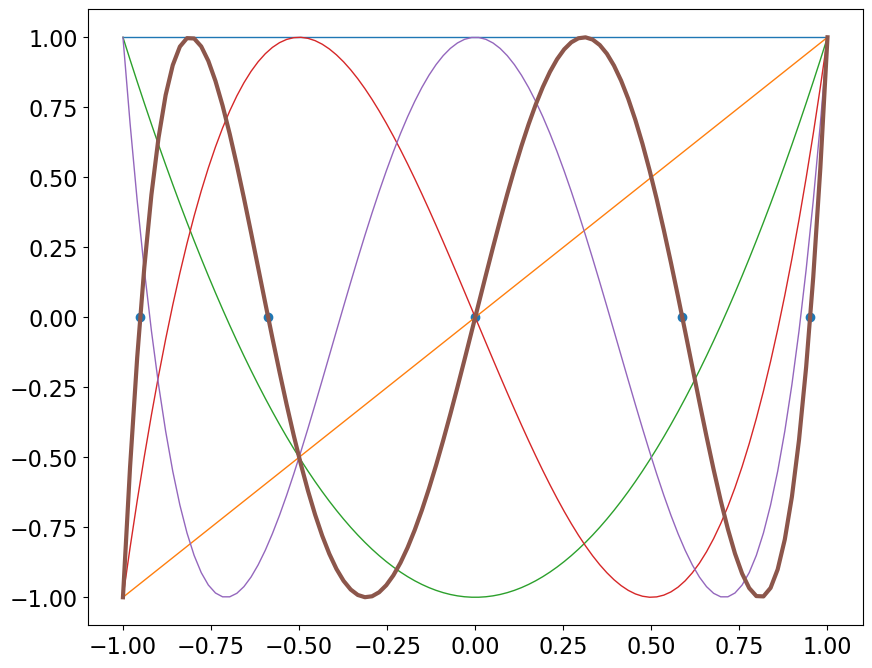

In [6]:
n=5
# plot nodes
x0,z0 =sieve.grid(n=n, a=0, b=1, gridtype='c') # chebyshev nodes are roots of n-degree chebyshev polynomials
plt.figure(figsize=(10,8))
plt.scatter(z0, z0*0)

# plot Chebyshev polynomials up to degree n
z=np.linspace(-1,1,100).reshape(-1,1)
B=sieve.basis_j(z, deg=n, btype='chebyshev') 
# B=sieve.basis(z, deg=[n], btype=['algpol']) # Try this and increase degree (does the polynobials appears to be orthogonal)
plt.plot(z, B[:,:-1], linewidth=1)
plt.plot(z, B[:,-1], linewidth=3)
plt.show()


### Are Chebyshev and Algebraic polynomials orthogonal

In [7]:
n=5;deg=n-1;                                             # Try more points with fixed degree - are Chebyshev still orthogonal?
sa=sieve(n, deg, a, b, btype='algpol', gridtype='u');    # basis: (ordinary) Algrbraic polynomials
sc=sieve(n, deg, a, b, btype='chebyshev', gridtype='c'); # basis: Chebyshev polynomials (TRY gridtype='u' - are Chebyshev still orthogonal?)
print('Algebraic polynomials')
disp(sa.B.T@sa.B)
print('Chebyshev polynmials')
disp(sc.B.T@sc.B)

Algebraic polynomials
  5.0000   0.0000   2.5000   0.0000   2.1250 
  0.0000   2.5000   0.0000   2.1250   0.0000 
  2.5000   0.0000   2.1250   0.0000   2.0312 
  0.0000   2.1250   0.0000   2.0312   0.0000 
  2.1250   0.0000   2.0312   0.0000   2.0078 
Chebyshev polynmials
  5.0000  -0.0000  -0.0000  -0.0000  -0.0000 
 -0.0000   2.5000  -0.0000  -0.0000   0.0000 
 -0.0000  -0.0000   2.5000   0.0000  -0.0000 
 -0.0000  -0.0000   0.0000   2.5000  -0.0000 
 -0.0000   0.0000  -0.0000  -0.0000   2.5000 


#### General interval

- Not hard to adapt the polynomials for the general interval
  $ [a,b] $ through linear change of variable  


$$
y = 2\frac{x-a}{b-a}-1
$$

- Orthogonality holds with weights function with the same change of
  variable  

#### Chebyshev approximation algorithm

1. Given $ f(x) $ and $ [a,b]$  
1. Compute Chebyshev interpolation nodes $z_i \in [-1,1] $  
1. Adjust nodes by change of variable, $ x_i \in  [a,b]  $  
1. Evaluate $ f $ at the nodes, $ f(x_i) $  
1. Compute matrix of Chebyshev polynomials evalauted at nodes $T_i(z_i) $ using OLS
1. Compute Chebyshev coefficients $ \alpha_i $ using OLS
1. Evaluate approximating polynomial at $x$ adjusted to $[-1,1]$ interval


$$
f(x) \approx \sum_{i=0}^n \alpha_i T_i(x)
$$

#### Accuracy of Chebyshev interpolation

Suppose $ f: [-1,1]\rightarrow R $ is $ C^k $ function for some
$ k\ge 1 $, and let $ I_n $ be the degree $ n $ polynomial
interpolation of $ f $ with nodes at zeros of $ T_{n}(x) $.
Then

$$
\lVert f - I_n \rVert_{\infty} \le \left( \frac{2}{\pi} \log(n+1) +1 \right) \frac{(n-k)!}{n!}\left(\frac{\pi}{2}\right)^k \lVert f^{(k)}\rVert_{\infty}
$$

📖 Judd (1988) Numerical Methods in Economics

- achieves *best polynomial approximation in uniform norm*  
- works for smooth functions
- easy to compute  
- but *does not* approximate $ f'(x) $ well  

In [8]:
# compute factor proportional to ||f(k)|| appearing in error
import math
k=10
for n in range(k,k+5,1):
    z=(   (2/math.pi*math.log(n+1)+1)*(math.factorial(n-k)/math.factorial(n)*(math.pi/2)**k) ) /(math.factorial(2*n+1) * math.factorial(2*n)**2)
    print('k=', k, 'n=', n,  'z=', z)

k= 10 n= 10 z= 2.1055718557301428e-61
k= 10 n= 11 z= 1.8111803736437962e-70
k= 10 n= 12 z= 1.6837155812491694e-79
k= 10 n= 13 z= 1.3335090940714706e-88
k= 10 n= 14 z= 8.344263840156263e-98


### Limits to polynomial interpolation/approximation 

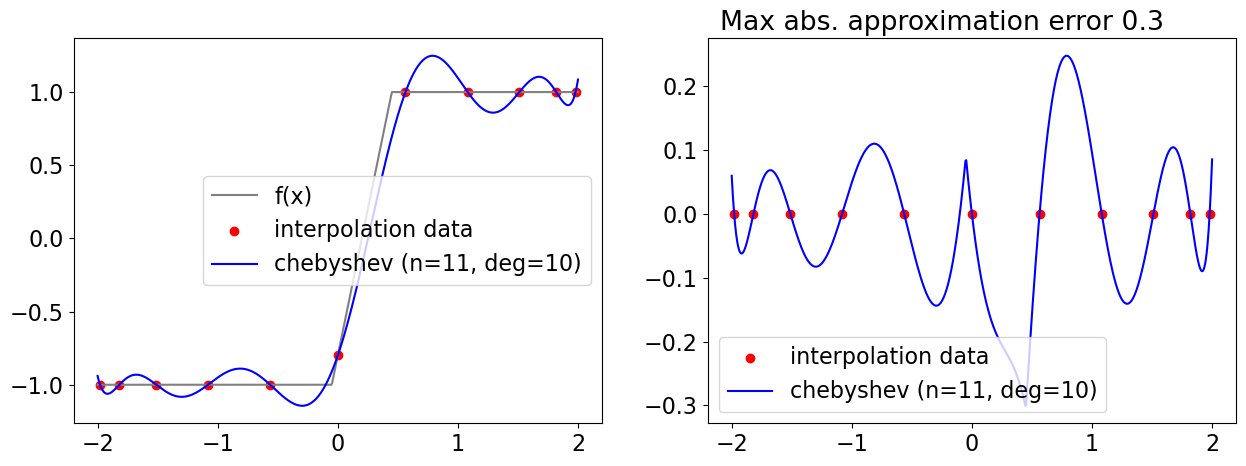

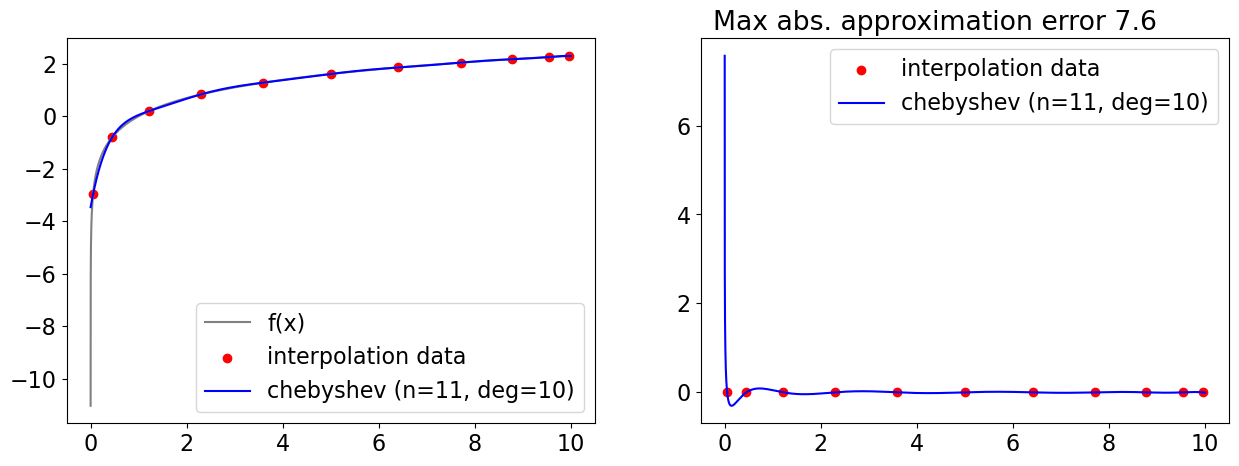

In [9]:
f1 = lambda x: np.minimum(np.maximum(4*(x-0.2),-1),1)   # function to approximate (for a=-1,b=1)
#f1= lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)       # function to interpolate/approximate (smooth on small intervals)
f2 = lambda x: np.log(x)                               # function to approximate (only for x>0)
deg=10; n=deg+1;    # Try increasing degree and number of nodes
btype='chebyshev'; gridtype='c'; # 
# btype='algpol'; gridtype='u'; # Try algpol
s1=sieve(n, deg, a=-2, b=2,   btype=btype, gridtype=gridtype);  
s2=sieve(n, deg, a=0.00001, b=10, btype=btype, gridtype=gridtype);  
s1.plot1d(f1); plt.show() # basis: Chebyshev polynomials 
s2.plot1d(f2); plt.show() # basis: (ordinary) Algrbraic polynomials

### Transformation - what if we could approximate a transformation of $f(x)$

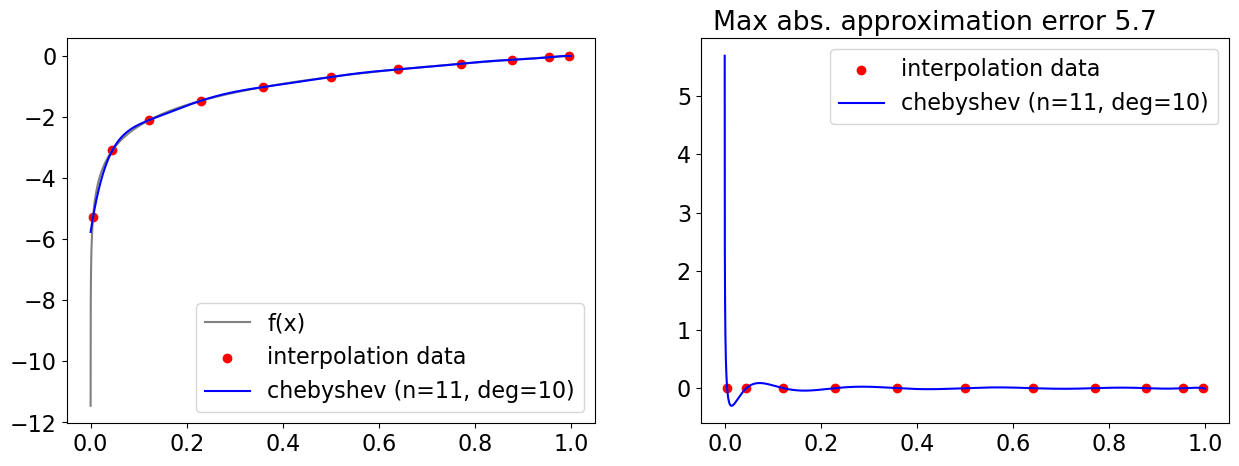

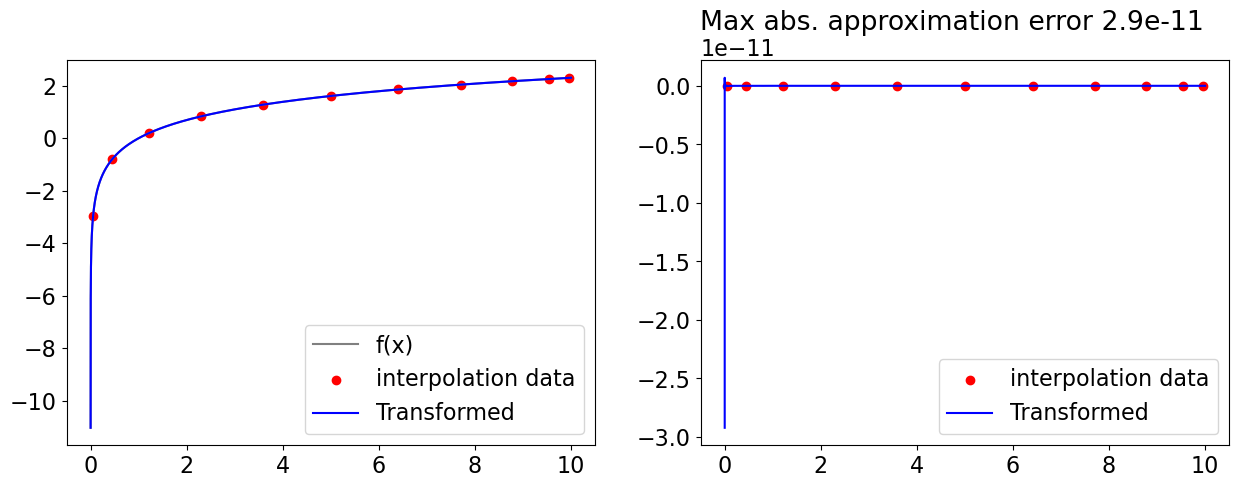

In [10]:
deg=10; n=deg+1;    # Try increasing degree and number of nodes
f1 = lambda x: np.log(x)  # function to approximate (only for x>0)
β=0.8; V= lambda x: np.log(x)/(1-β) + np.log(1-β)/(1-β) + β *np.log(β)/((1-β)**2)
# f1 = V # TRY Value function for cake eating problem
btype='chebyshev'; gridtype='c'; 
s=sieve(n, deg, a=0.00001, b=1, btype=btype, gridtype=gridtype);  
s_tr=sieve(n, deg, a=0.00001, b=10, btype=btype, gridtype=gridtype, transform=lambda x: np.exp(x), inv_transform=lambda x: np.log(np.maximum(x, 1e-20)));  
s.plot1d(f1); plt.show() # basis: Chebyshev polynomials 
s_tr.plot1d(f1, label='Transformed'); plt.show() # basis: (ordinary) Algrbraic polynomials

### Extrapolation

Extrapolation is computing the approximated function outside of the
original data interval

**Should be avoided in general**

- Exact *only* when theoretical properties of the extrapolated function
  are known  
- Can be used with extreme caution and based on the analysis of the model  
- Always try to introduce wider bounds for the grid instead  

**NEVER extrapolate high degree polynomials.**: Nodes are like hands that tries to fix a wild snake. 

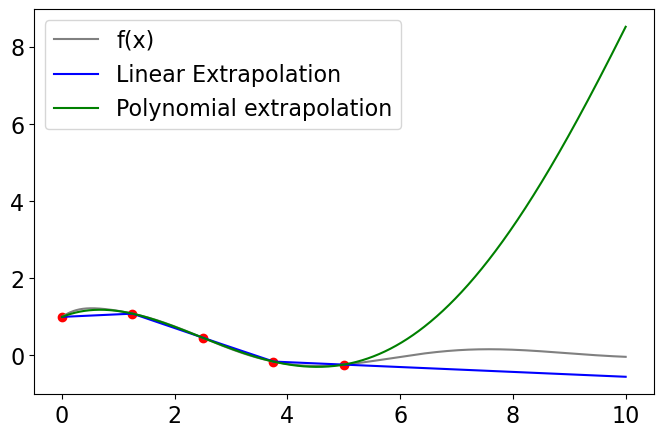

In [11]:
m=5; a=0; b=5; extrapolate=5            # try increasing m (does linear gets worse, does polynmial)               
x0 = np.linspace(a,b,m);                 # x0:  grid points where we know f(x)
x1 =  np.linspace(a,b+extrapolate,100);            # x1:  extended grid points for extrapolation
f= lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)       # function to interpolate/approximate (smooth on small intervals)
fhat = interpolate.interp1d(x0,f(x0), bounds_error=False, fill_value='extrapolate')    # returns the interpolation function
plot1d(None, x0, f(x0)) # use the the plotting tool
plot1d(f, x1, None, fhat, label='Linear Extrapolation') # use the the plotting tool
α = polynomial.polyfit(x0,f(x0),m-1)     # returns polynomial coeficients
fhat = lambda x: polynomial.polyval(x,α)
plot1d(None, x1, None, fhat, label='Polynomial extrapolation', color='g') # use the the plotting tool
    

### Spline interpolation

Spline = curve composed of independent pieces

**Definition** A function $ s(x) $ on $ [a,b] $ is a spline of
order $ n $ ( = degree $ n-1 $) iff

- $ s $ is $ C^{n-2} $ on $ [a,b] $ (has continuous derivatives
  up to order $ n-2 $),  
- given *knot* points $ a=x_0<x_1<\dots<x_m=b $, $ s(x) $ is a
  polynomial of degree $ n-1 $ on each subinterval
  $ [x_i,x_{i+1}] $, $ i=0,\dots,m-1 $  

#### Cubic splines = spline of order 4

- Data set $ \{(x_i,f(x_i), i=0,\dots,n\} $  
- Functional form $ s(x) = a_i + b_i x + c_i x^2 + d_i x^3 $ on
  $ [x_{i-1},x_i] $ for $ i=1,\dots,n $  
- $ 4n $ unknown coefficients:  
- $ 2n $ equations to make sure each segment passes through its interval points +
  $ 2(n-1) $ equations to ensure two continuous derivatives at each interior point  
- Additional 2 equation for the $ x_0 $ and $ x_n $  
  - $ s''(x_0)=s''(x_n)=0 $ (natural spline)  
  - $ s'(x_0)=\frac{s(x_1)-s(x_0)}{x_1-x_0} $,
    $ s'(x_n)=\frac{s(x_n)-s(x_{n-1})}{x_n-x_{n-1}} $
    (secant-Hermite)  

### B-splines
- B-splines play the role of basis functions for the spline function space, hence the name. 
- Expressions for the polynomial (all of same degree k) pieces can be derived by means of the Cox–de Boor recursion formula
$$ B_{i,0}(x):={\begin{cases}1&{\text{if }}t_{i}\leq x<t_{i+1},\\0&{\text{otherwise}}.\end{cases}}$$

$$B_{i,k}(x):={\frac {x-t_{i}}{t_{i+k}-t_{i}}}B_{i,k-1}(x)+{\frac {t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}}B_{i+1,k-1}(x).$$
- That is, $B_{j,0}(x)$ is piecewise constant one or zero indicating which knot span $x$ is in (zero if knot span j is repeated). 
- The recursion equation is in two parts, where
$${\frac {x-t_{i}}{t_{i+k}-t_{i}}}$$
ramps from zero to one as $x$ goes from $t_{i}$ to $t_{i+k}$, and $${\frac {t_{i+k+1}-x}{t_{i+k+1}-t_{i+1}}}$$ ramps from one to zero as x goes from 
$t_{i+1}$ to $t_{i+k+1}$. 

### B-splines  - basis functions

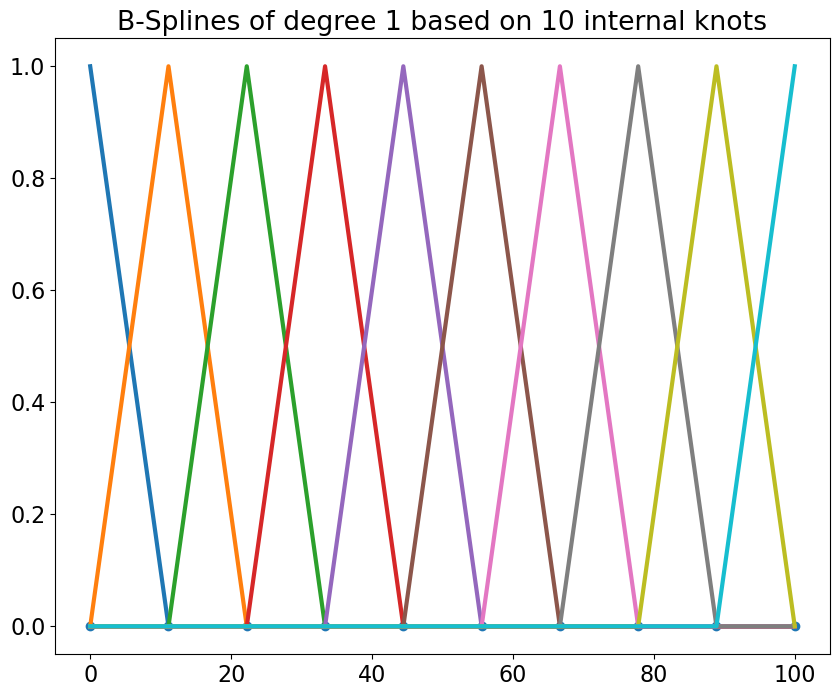

In [12]:
k=1                            # polynomial degree (Try 0,1,2,)
nknots=10                      # number of internal knots (Try)
a=0; b=100;                    # min and max
knots=np.linspace(a,b,nknots)  # internal knots
x=np.linspace(a,b,1000)        # evaluation point for plotting
B=sieve.basis_j(x, deg=k, btype='b-spline', knots=knots) 
plt.figure(figsize=(10,8))
plt.scatter(knots, knots*0)
plt.plot(x, B, linewidth=3)
plt.title('B-Splines of degree %d based on %d internal knots'% (k,nknots))
plt.show()

### B-splines versus Chebyshev 

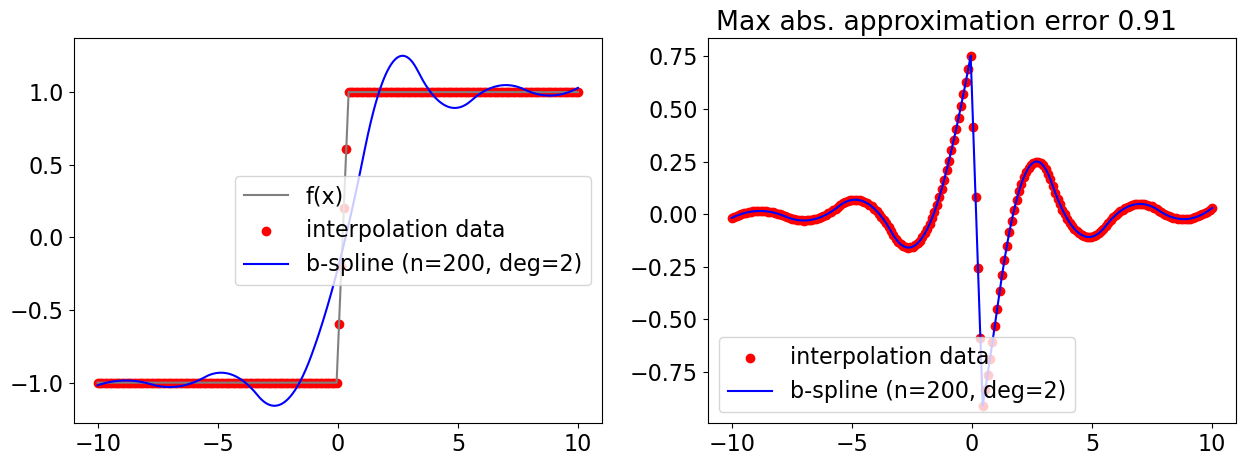

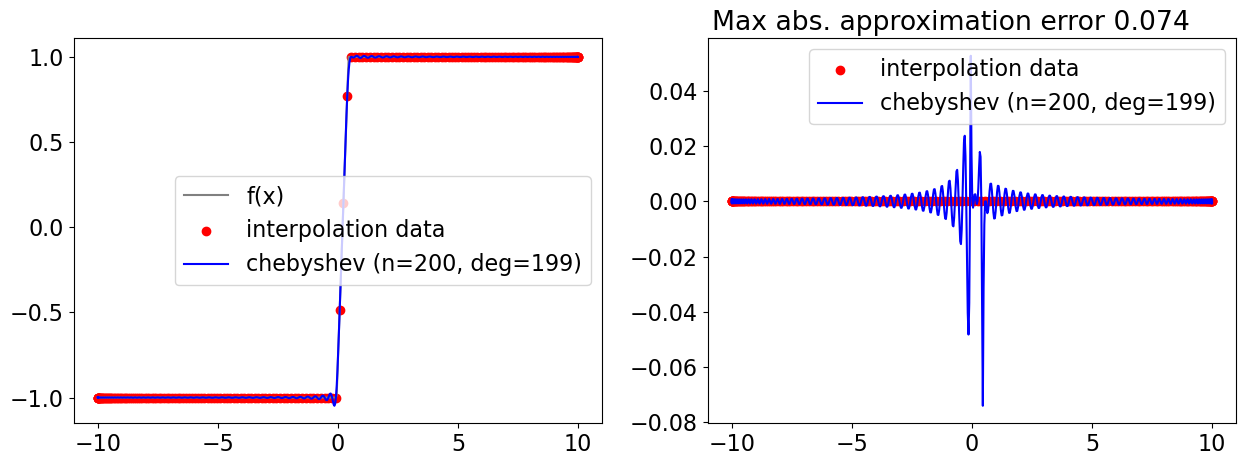

In [13]:
a=-10; b=10; f = lambda x: np.minimum(np.maximum(4*(x-0.2),-1),1)   # "kinky" function to approximate (for a=-1,b=1)
# a=-1; b=1; f = lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2)      # smooth function 
n=200; deg_spl=2; # Try chnaging degree of spline, addining more points and change interval.  
sb=sieve(n, deg_spl, a, b, btype='b-spline', gridtype='u', nknots=10);      
sb.plot1d(f); plt.show() # basis: B-spline
sc=sieve(n, n-1, a, b, btype='chebyshev', gridtype='c');   sc.plot1d(f); plt.show() # basis: Chebyshev polynomials

### Multidimensional interpolation/approximation

- there are multidimensional generalization to all methods based on sieves  
- We consider a tensor product basis: curse of dimensionality in the number of interpolation points when number of dimensions increase  

**Generally much harder!**

### We can do it: Let's try a tensor product basis of Chebyshev polynomials

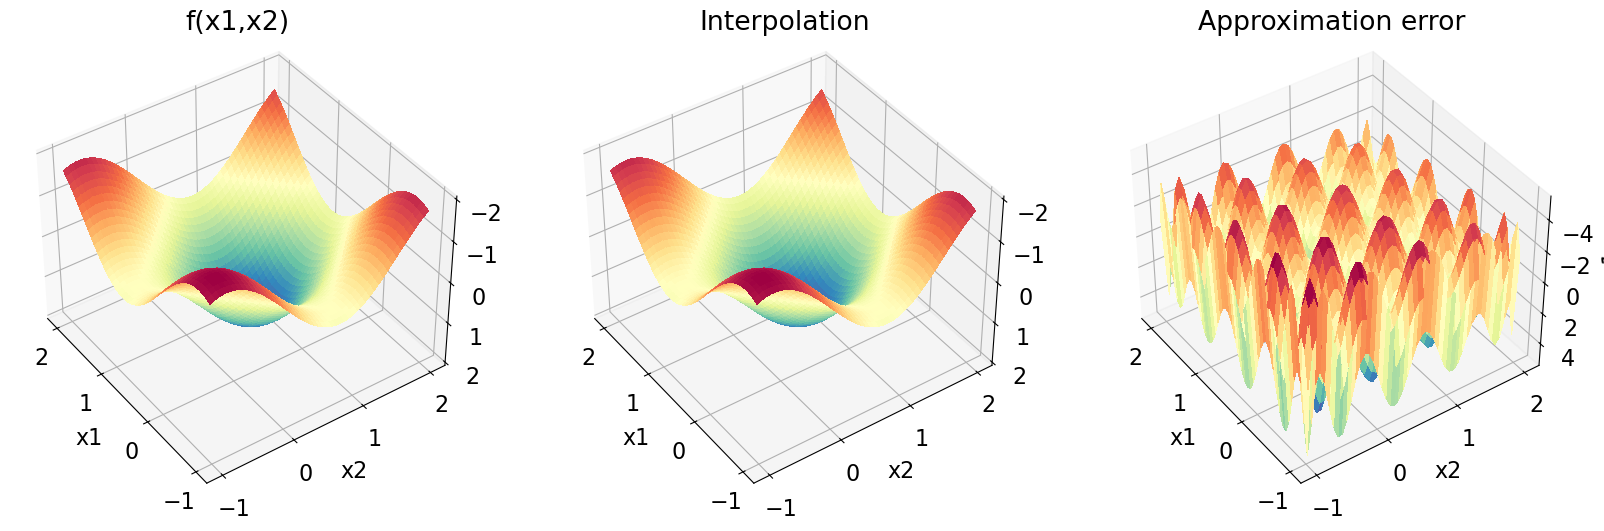

In [14]:
f1 = lambda x: np.sin(np.sum(x, axis=1)).reshape(-1,1)           # smooth function with some nonlinear interaction
f1 = lambda x: np.sum(np.sin(2*x), axis=1).reshape(-1,1)         # additively seperable smooth function
#f1 = lambda x: np.log(np.sum(np.abs(x), axis=1)).reshape(-1,1)  # nasty fuction
s1=sieve(n=[11, 11], a=-1, b=2, btype='chebyshev', gridtype='c') # sieve setup
fx=f1(s1.x)        # y-data at nodes s1.x
α = s1.fit(fx)     # sieve coeficients             

neval=[50,50]      # evaluation of function and interpolant on finer grid  
x, z=sieve.grid(n=neval, a=s1.a, b=s1.b, gridtype='u')
fhat=s1.eval(x, α)

# plotting
fig=plot2d(x,f1(x), neval, i=1)
fig=plot2d(x,fhat, neval, fig=fig, i=2, label='Interpolation')
fig=plot2d(x,fhat-f1(x), neval, fig=fig, i=3, label='Approximation error')

### Approximation in $R^d$
Recall our sieve approximation in the 1-dimensional case
$$f(x) \approx s(x,\alpha)= \sum_{j=0}^{n} \alpha_j B_j(x) $$
where 
- $B_j(x)=B_{j,k}(x)$ for the B-Spline of degree $k$ for interval $j$ (sorry for using same notation for B splines and Basis functions)
- $B_j(x)=B_{j,0}(x)=\mathbb{1}(x_j\le x < x_{j+1}) $ the step-function (B-spline of degree 0 for interval j)
- $B_j(x)=x^j$ for a simple algebraic polynomial of degree $j$ 
- $B_j(x)=T_j(x)$ for Chebyshev polynomials of degree $j$

This formula can be directly generalized to d dimensions:
$$f(x_1,\dots,x_d) \approx s(x_1,\dots,x_d,\alpha)=  \sum_{i_1=0}^{n_1} \dots \sum_{i_d=0}^{n_d}  \alpha_{i_1\dots 
i_d} \prod_{k=1}^d B_{i_k}(x_{k})$$
For d=2 we have
$$f(x_1,x_2) \approx s(x_1,x_2,\alpha)=  \sum_{i_1=0}^{n_1} \sum_{i_2=0}^{n_2}  \alpha_{i_1,
i_2}  B_{i_1}(x_{1}) B_{i_2}(x_{2})$$

### Looks nasty, but is quite easy with matrix notation
$$f(x_1,\dots,x_d)=\mathbf{B(x)}\alpha$$ 
where 
- $\mathbf{B(x)}$ is the matrix with as many rows as we have grid-points and as many columns as we cam make combinations of basis functions across the $d$ dimensions d with $n_d+1$ basis functions in each dimension. 
- $\mathbf{B(x)}$ has $\prod_{k=1}^d (n_d+1)$ columns.
- $\alpha$ is a vector of coefficients with $\prod_{k=1}^d (n_d+1)$ rows
- To identify all coefficients we need at least $\prod_{k=1}^d (n_d+1)$ DISTRICT points on our grid. We can this as the so called Cartesian grid that gives all combinations of gridpoints used in dimensions $k=1,\dots,d$

### .... and even easier in Python. Let's first do the Cartesian grid

In [15]:
def cartesian(x):
    d=len(x)
    return np.array(np.meshgrid(*x)).T.reshape(-1,d)

x1=np.linspace(1,2,2); x2=np.linspace(3,5,3);  x=[x1, x2]; 
X=cartesian(x)
print('x1=', x1)
print('x2=', x2)
print('X', X)
disp(X)


x1= [1. 2.]
x2= [3. 4. 5.]
X [[1. 3.]
 [1. 4.]
 [1. 5.]
 [2. 3.]
 [2. 4.]
 [2. 5.]]
  1.0000   3.0000 
  1.0000   4.0000 
  1.0000   5.0000 
  2.0000   3.0000 
  2.0000   4.0000 
  2.0000   5.0000 


### .... and now the d fold tensor product basis

In [16]:
def tensor(b): 
    '''k-fold tensor product list of matrices b=[b[0],b[1],...,b[k-1]]'''
    T=b[0]   # Initialize Tensor product basis with first element in b 
    for j in range(len(b)-1): # loop over remainng dimensions in b
        T=(T[:,:,None]*b[j+1][:,None,:]).reshape(T.shape[0],-1)  # use boradcasting
    return T

B1=sieve.basis_j(X[:,0], deg=2, btype='algpol')
B2=sieve.basis_j(X[:,1], deg=2, btype='algpol')

print('B1'); disp(B1)
print('B2'); disp(B2)

T=tensor([B1,B2])
print('T', T.shape); disp(T)

B1
  1.0000   1.0000   1.0000 
  1.0000   1.0000   1.0000 
  1.0000   1.0000   1.0000 
  1.0000   2.0000   4.0000 
  1.0000   2.0000   4.0000 
  1.0000   2.0000   4.0000 
B2
  1.0000   3.0000   9.0000 
  1.0000   4.0000  16.0000 
  1.0000   5.0000  25.0000 
  1.0000   3.0000   9.0000 
  1.0000   4.0000  16.0000 
  1.0000   5.0000  25.0000 
T (6, 9)
  1.0000   3.0000   9.0000   1.0000   3.0000   9.0000   1.0000   3.0000   9.0000 
  1.0000   4.0000  16.0000   1.0000   4.0000  16.0000   1.0000   4.0000  16.0000 
  1.0000   5.0000  25.0000   1.0000   5.0000  25.0000   1.0000   5.0000  25.0000 
  1.0000   3.0000   9.0000   2.0000   6.0000  18.0000   4.0000  12.0000  36.0000 
  1.0000   4.0000  16.0000   2.0000   8.0000  32.0000   4.0000  16.0000  64.0000 
  1.0000   5.0000  25.0000   2.0000  10.0000  50.0000   4.0000  20.0000 100.0000 


### Before we look at coefficients let's consider our 2-d Chebyshev approximation from before

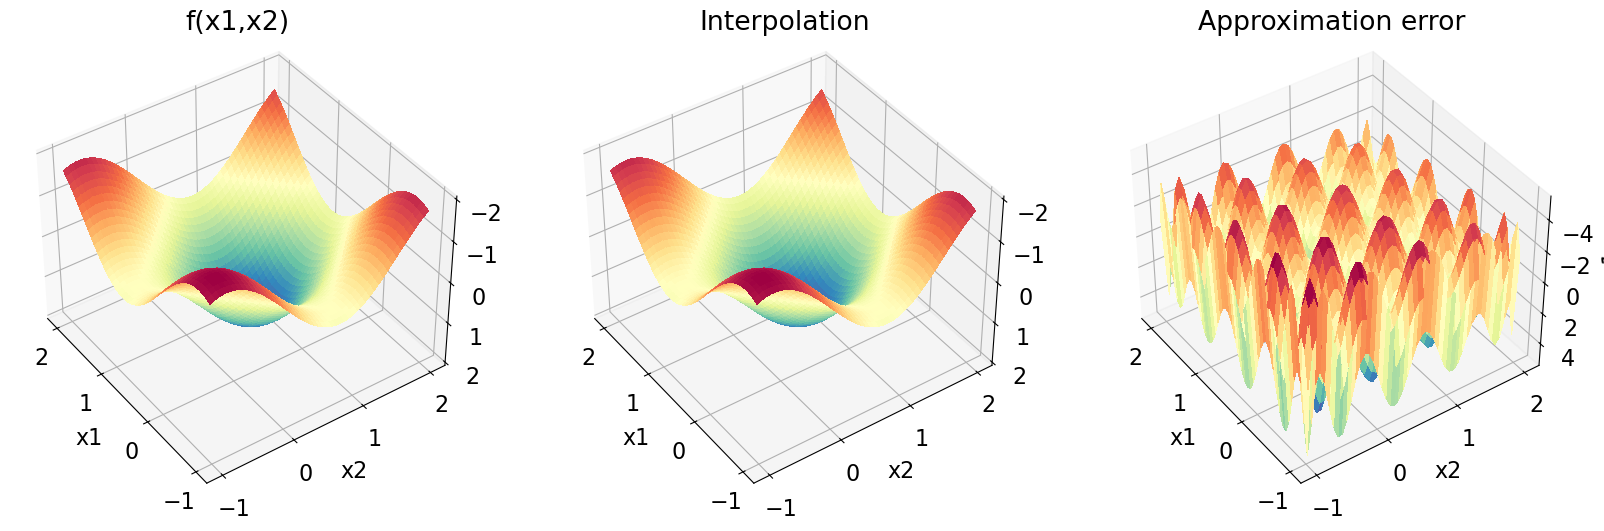

In [17]:
# f1 = lambda x: np.sin(np.sum(x, axis=1)).reshape(-1,1)         # smooth function with some nonlinear interaction (TRY and inspect coefficnets on next slide)
f1 = lambda x: np.sum(np.sin(2*x), axis=1).reshape(-1,1)         # additively seperable smooth function (TRY and inspect coefficnets on next slide)
#f1 = lambda x: np.log(np.sum(np.abs(x), axis=1)).reshape(-1,1)  # nasty fuction
s1=sieve(n=[11, 11], a=-1, b=2, btype='chebyshev', gridtype='c') # sieve setup
fx=f1(s1.x)        # y-data at nodes s1.x
α = s1.fit(fx)     # sieve coeficients             

neval=[50,50]      # evaluation of function and interpolant on finer grid  
x, z=sieve.grid(n=neval, a=s1.a, b=s1.b, gridtype='u')
fhat=s1.eval(x, α)

# plotting
fig=plot2d(x,f1(x), neval, i=1)
fig=plot2d(x,fhat, neval, fig=fig, i=2, label='Interpolation')
fig=plot2d(x,fhat-f1(x), neval, fig=fig, i=3, label='Approximation error')

### How does the coefficients look like?  

In [18]:
# Try to inspect coefficients when approximating function with dependence x1 and x2 
# (use one of the alternative functions just above)
print('Transposed coefficients')
disp(α.reshape(s1.deg[0]+1,s1.deg[1]+1)) 

Transposed coefficients
 -0.4377   0.3664  -0.8181  -0.3340   0.2222   0.0465  -0.0192  -0.0028   0.0008   0.0001  -0.0000 
  0.3664  -0.0000  -0.0000   0.0000  -0.0000  -0.0000   0.0000  -0.0000   0.0000  -0.0000   0.0000 
 -0.8181   0.0000  -0.0000  -0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000   0.0000  -0.0000 
 -0.3340   0.0000  -0.0000  -0.0000   0.0000   0.0000  -0.0000  -0.0000   0.0000   0.0000   0.0000 
  0.2222   0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000   0.0000   0.0000  -0.0000   0.0000 
  0.0465  -0.0000  -0.0000   0.0000   0.0000  -0.0000  -0.0000   0.0000   0.0000  -0.0000  -0.0000 
 -0.0192  -0.0000  -0.0000  -0.0000  -0.0000  -0.0000   0.0000   0.0000   0.0000   0.0000  -0.0000 
 -0.0028  -0.0000  -0.0000  -0.0000   0.0000  -0.0000   0.0000  -0.0000  -0.0000   0.0000   0.0000 
  0.0008   0.0000  -0.0000   0.0000   0.0000   0.0000  -0.0000   0.0000  -0.0000  -0.0000   0.0000 
  0.0001  -0.0000   0.0000   0.0000  -0.0000   0.0000   0.0000  -0.0000  -0.

### Let's try a tensor product basis of B-splines

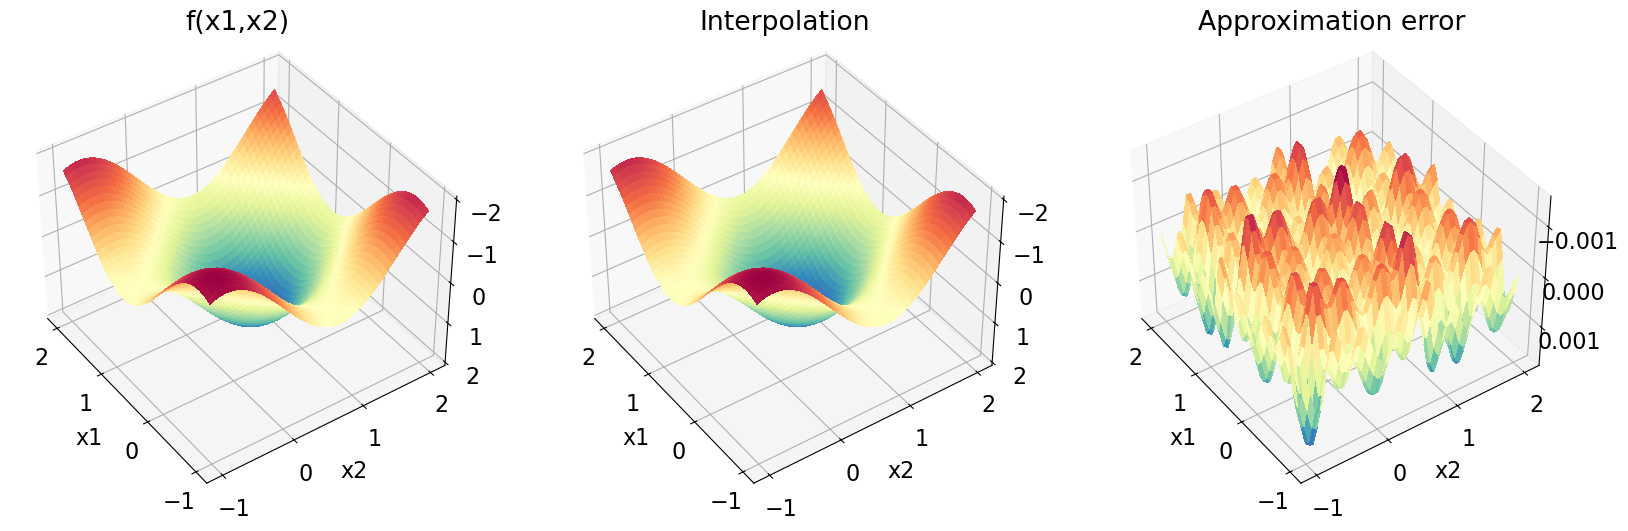

In [19]:
f1 = lambda x: np.sin(np.sum(x, axis=1)).reshape(-1,1)           # smooth function with some nonlinear interaction
f1 = lambda x: np.sum(np.sin(2*x), axis=1).reshape(-1,1)         # additively seperable smooth function
#f1 = lambda x: np.log(np.sum(np.abs(x), axis=1)).reshape(-1,1)  # nasty fuction
s1=sieve(n=[11, 11], deg=[3], a=-1, b=2, btype=['b-spline'], gridtype=['u']) # sieve setup - try different defgrees
#s1=sieve(n=[11, 11], deg=[3,10], a=-1, b=2, btype=['b-spline','chebyshev'], gridtype=['u','c']) # sieve setup - try different defgrees
fx=f1(s1.x)        # y-data at nodes s1.x
α = s1.fit(fx)     # sieve coeficients             

neval=[50,50]      # evaluation of function and interpolant on finer grid  
x, z=sieve.grid(n=neval, a=s1.a, b=s1.b, gridtype='u')
fhat=s1.eval(x, α)

# plotting
fig=plot2d(x,f1(x), neval, i=1)
fig=plot2d(x,fhat, neval, fig=fig, i=2, label='Interpolation')
fig=plot2d(x,fhat-f1(x), neval, fig=fig, i=3, label='Approximation error')

### Coefficients for Spline approximation is dense

In [20]:
print('Transposed coefficients')
disp(α.reshape(s1.nknots[0]+2,s1.nknots[1]+2)) 
     

Transposed coefficients
 -1.8186  -1.9221  -1.9525  -1.4364  -0.6368   0.0145   0.1720  -0.2510  -1.0291  -1.5028  -1.6661 
 -1.9221  -2.0257  -2.0560  -1.5400  -0.7404  -0.0891   0.0684  -0.3546  -1.1326  -1.6063  -1.7696 
 -1.9525  -2.0560  -2.0863  -1.5703  -0.7707  -0.1194   0.0381  -0.3849  -1.1630  -1.6366  -1.8000 
 -1.4364  -1.5400  -1.5703  -1.0543  -0.2547   0.3966   0.5541   0.1311  -0.6469  -1.1206  -1.2839 
 -0.6368  -0.7404  -0.7707  -0.2547   0.5449   1.1962   1.3537   0.9307   0.1527  -0.3210  -0.4843 
  0.0145  -0.0891  -0.1194   0.3966   1.1962   1.8475   2.0050   1.5820   0.8040   0.3303   0.1670 
  0.1720   0.0684   0.0381   0.5541   1.3537   2.0050   2.1625   1.7395   0.9615   0.4878   0.3245 
 -0.2510  -0.3546  -0.3849   0.1311   0.9307   1.5820   1.7395   1.3165   0.5385   0.0648  -0.0985 
 -1.0291  -1.1326  -1.1630  -0.6469   0.1527   0.8040   0.9615   0.5385  -0.2396  -0.7133  -0.8766 
 -1.5028  -1.6063  -1.6366  -1.1206  -0.3210   0.3303   0.4878   0.0648  -0.

### Curse of dimensionality
- It may be easy to program, but the tensor product basis i subject to **CURSE OF DIMENSIONALITY**. 
- The number of basis functions, corresponding coefficients and required nodes are all exponentially increasing in $d$
- Sparse Smolyak grids and adaptive sparse grids  
- Do we need the regular Cartesian grid
- Perhaps randomization can break the curse of dimensionality
- Irregular grids require computationally expensive triangulation in the general case
- Good application for machine learning!  

### Further learning resources

- [https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)  
- [https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html)  
- M.H. Mudde’s thesis on Chebyshev approximation [http://fse.studenttheses.ub.rug.nl/15406/1/Marieke_Mudde_2017_EC.pdf](http://fse.studenttheses.ub.rug.nl/15406/1/Marieke_Mudde_2017_EC.pdf)  

# Some calls and illustrations using build in Python routines in 1d


In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(2008) # fix random number sequences
x  = np.sort(np.random.uniform(-5,10,12)) # sorted random numbers on [-5,10]
xr = np.linspace(-5,10,12) # regular grid on [-5,10]

func=lambda x: np.exp(-x/4)*np.sin(x) + 1/(1+x**2) # function to interpolate

In [22]:
def plot1(ifunc,fdata=(x,func(x)),f=func,color='b',label='',extrapolation=False):
    '''helper function to make plots'''
    xd = np.linspace(-5,10,1000) # for making continuous lines
    plt.figure(num=1, figsize=(10,8))
    plt.scatter(fdata[0],fdata[1],color='r') # interpolation data
    plt.plot(xd,f(xd),color='grey') # true function
    if extrapolation:
        xdi = xd
    else:
        # restriction for interpolation only
        xdi=xd[np.logical_and(xd>=fdata[0][0],xd<=fdata[0][-1])]
    if ifunc:
        plt.plot(xdi,ifunc(xdi),color=color,label=label)
        if label:
            plt.legend()
    elif label:
        plt.title(label)

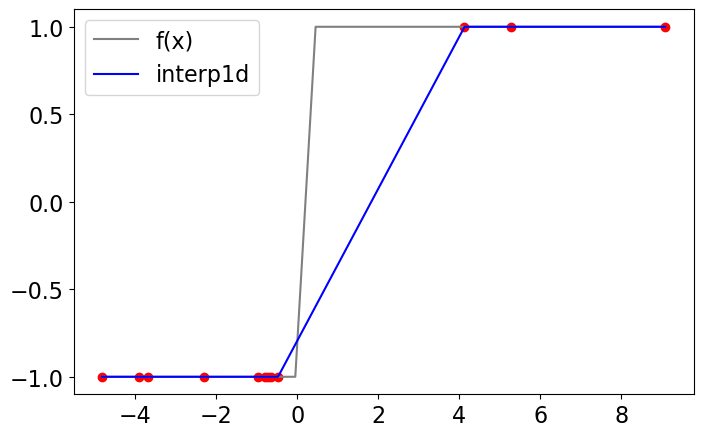

In [23]:
from scipy import interpolate # Interpolation routines
fhat = interpolate.interp1d(x,f(x)) # returns the interpolation function
plot1d(f, x, f(x), fhat,label='interp1d')

In [24]:
help(interpolate.interp1d)

Help on class interp1d in module scipy.interpolate._interpolate:

class interp1d(scipy.interpolate._polyint._Interpolator1D)
 |  interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)
 |
 |  Interpolate a 1-D function.
 |
 |  .. legacy:: class
 |
 |      For a guide to the intended replacements for `interp1d` see
 |      :ref:`tutorial-interpolate_1Dsection`.
 |
 |  `x` and `y` are arrays of values used to approximate some function f:
 |  ``y = f(x)``. This class returns a function whose call method uses
 |  interpolation to find the value of new points.
 |
 |  Parameters
 |  ----------
 |  x : (npoints, ) array_like
 |      A 1-D array of real values.
 |  y : (..., npoints, ...) array_like
 |      A N-D array of real values. The length of `y` along the interpolation
 |      axis must be equal to the length of `x`. Use the ``axis`` parameter
 |      to select correct axis. Unlike other interpolators, the default
 |      interpolation a

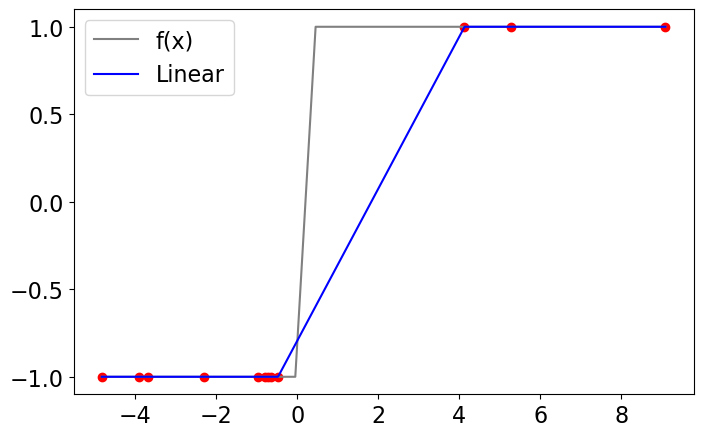

In [25]:
fhat = interpolate.interp1d(x,f(x),kind='linear')
plot1d(f, x, f(x), fhat,label='Linear')

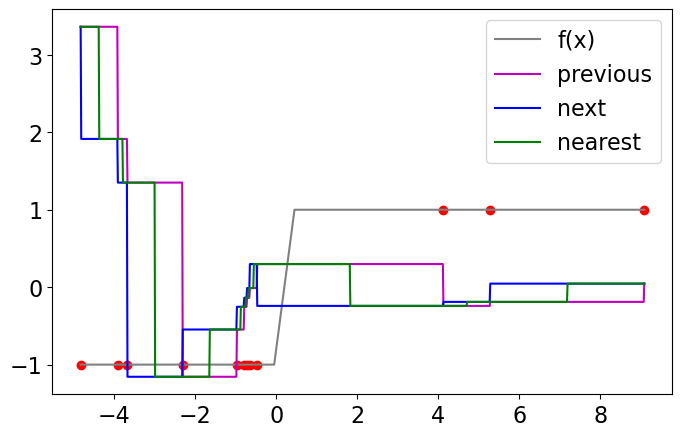

In [26]:
plot1d(f, x, f(x))
for knd, clr in ('previous','m'),('next','b'),('nearest','g'):
    fhat = interpolate.interp1d(x,func(x),kind=knd)
    plot1d(x0=x, fhat=fhat, label=knd,color=clr)
plt.show()

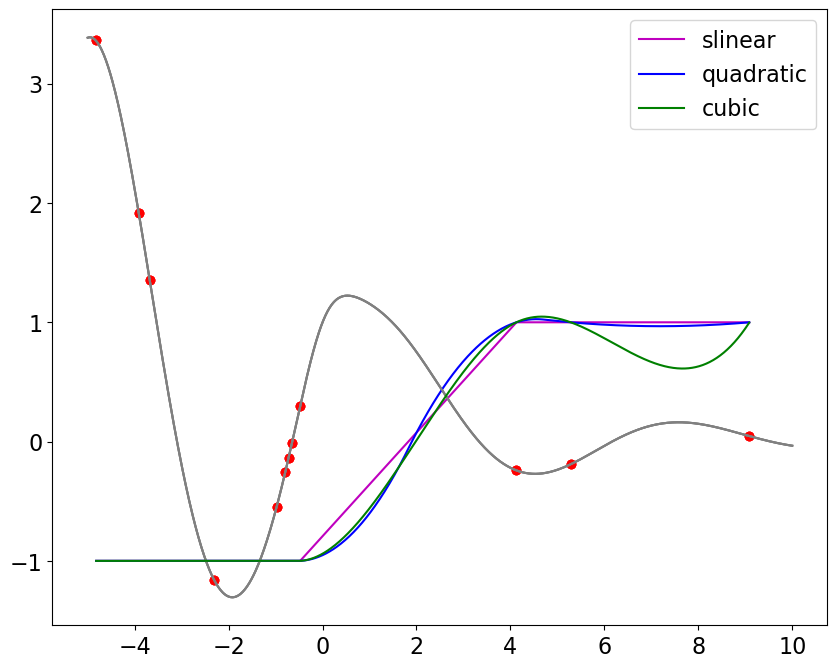

In [27]:
for knd, clr in ('slinear','m'),('quadratic','b'),('cubic','g'):
    fi = interpolate.interp1d(x,f(x),kind=knd)
    plot1(fi,color=clr,label=knd)

Max error with  slinear splines is 7.87872e-01
Max error with  quadratic splines is 5.17170e-01
Max error with  cubic splines is 5.06893e-01


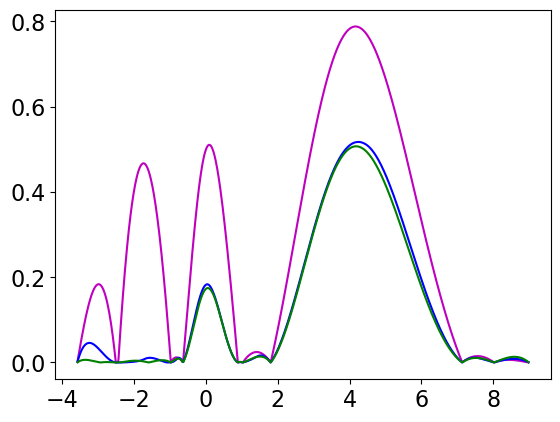

In [28]:
# Approximation errors
x = np.sort(np.random.uniform(-5,10,11))  # generate new data
for knd, clr in ('slinear','m'),('quadratic','b'),('cubic','g'):
    fi = interpolate.interp1d(x,func(x),kind=knd,bounds_error=False)
    xd = np.linspace(-5,10,1000)
    erd=np.abs(func(xd)-fi(xd))
    plt.plot(xd,erd,color=clr)
    print('Max error with  %s splines is %1.5e'%(knd,np.nanmax(erd)))

Max error with  slinear splines is 4.63043e-01
Max error with  quadratic splines is 3.48546e-01
Max error with  cubic splines is 1.89578e-01


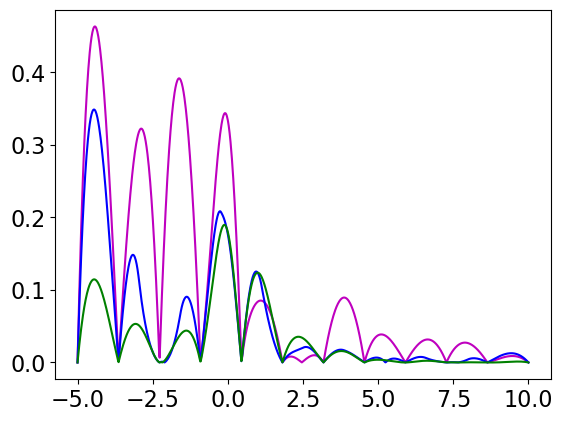

In [29]:
# Approximation errors for regular grid
for knd, clr in ('slinear','m'),('quadratic','b'),('cubic','g'):
    fi = interpolate.interp1d(xr,func(xr),kind=knd,bounds_error=False)
    xd = np.linspace(-5,10,1000)
    erd=np.abs(func(xd)-fi(xd))
    plt.plot(xd,erd,color=clr)
    print('Max error with  %s splines is %1.5e'%(knd,np.nanmax(erd)))

#### Accuracy of the interpolation

How to reduce approximation errors?

- Number of nodes (more is better)  
- Location of nodes (regular is better)  
- Interpolation type (match function of interest)  


*In economic models we usually can control all of these*

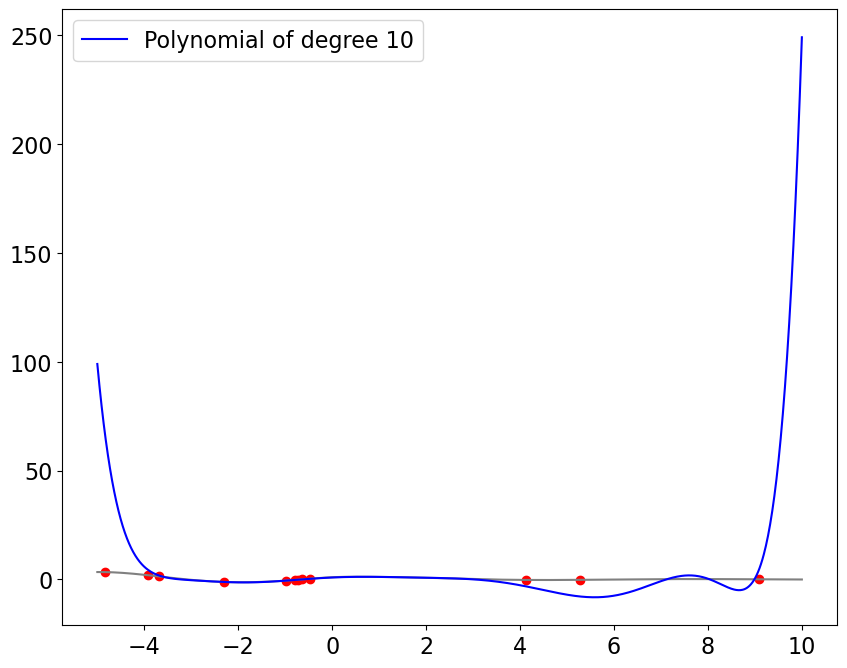

In [30]:
from numpy.polynomial import polynomial
degree = len(x)-1 # passing through all dots
p = polynomial.polyfit(x,func(x),degree)
fi = lambda x: polynomial.polyval(x,p)
plot1(fi,label='Polynomial of degree %d'%degree,extrapolation=True)

(12,)


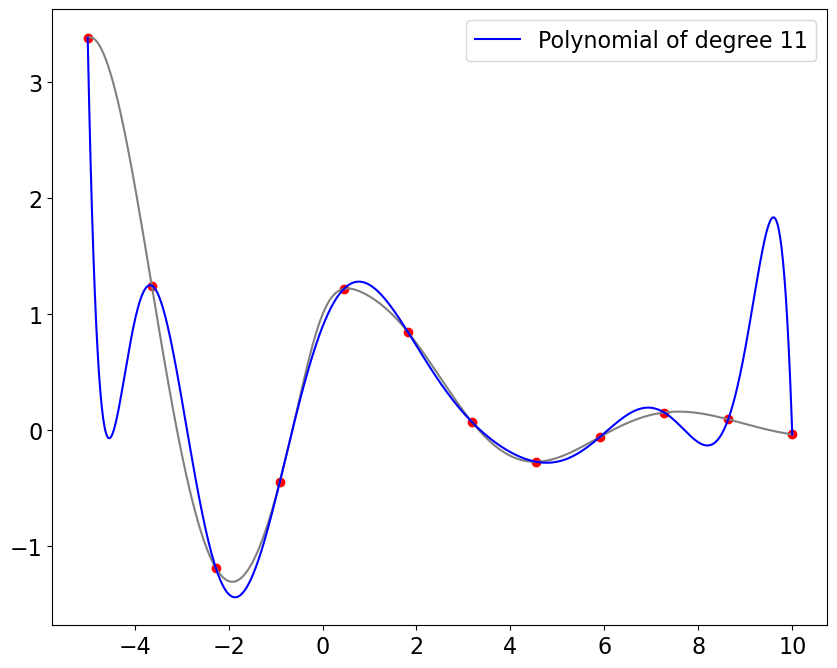

In [31]:
# now with regular grid
degree = len(xr)-1 # passing through all dots
p = polynomial.polyfit(xr,func(xr),degree)
print(p.shape)
fi = lambda x: polynomial.polyval(x,p)
plot1(fi,fdata=(xr,func(xr)),label='Polynomial of degree %d'%degree,extrapolation=True)

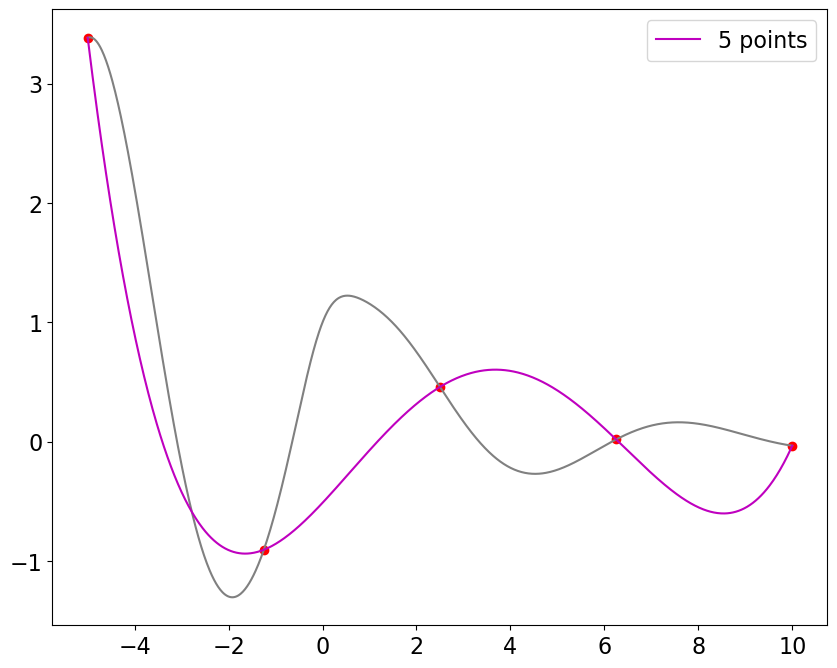

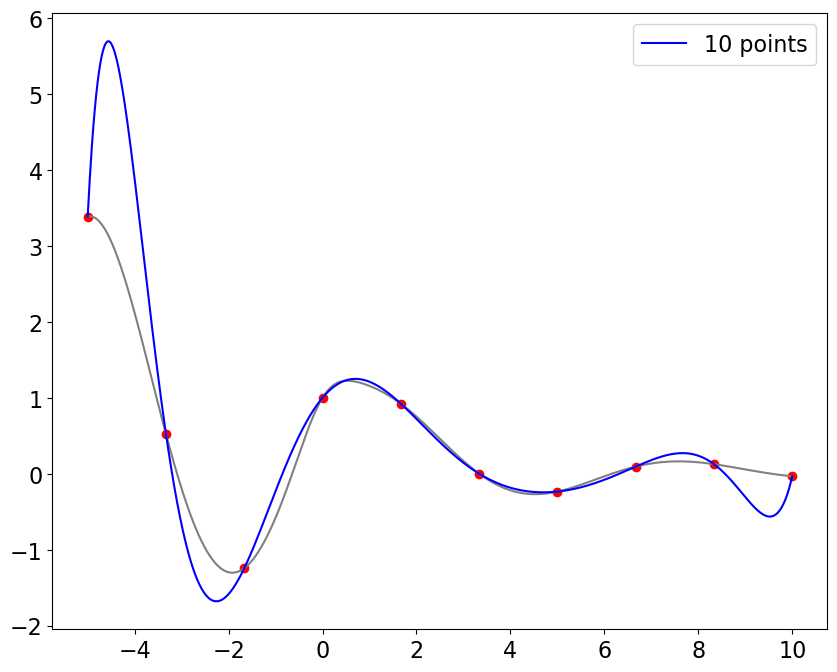

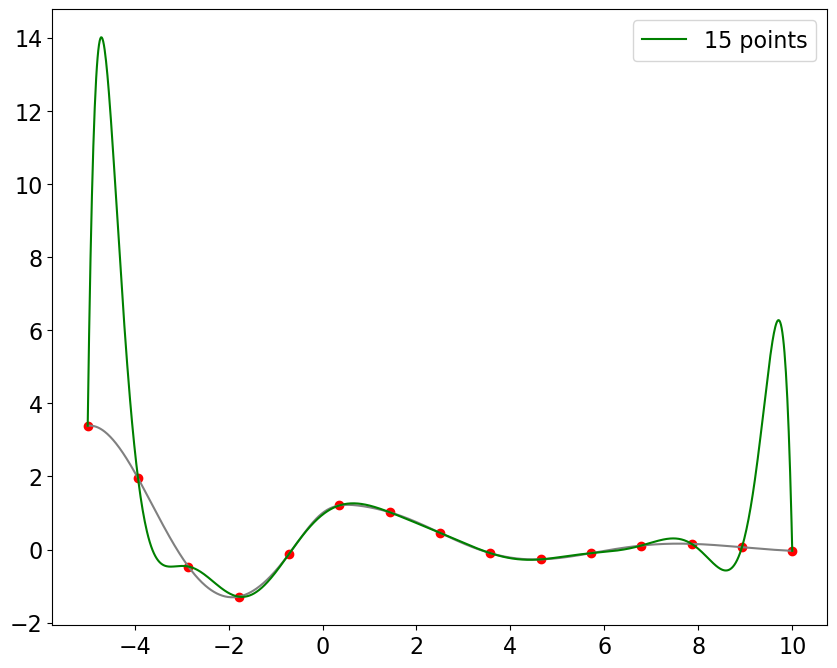

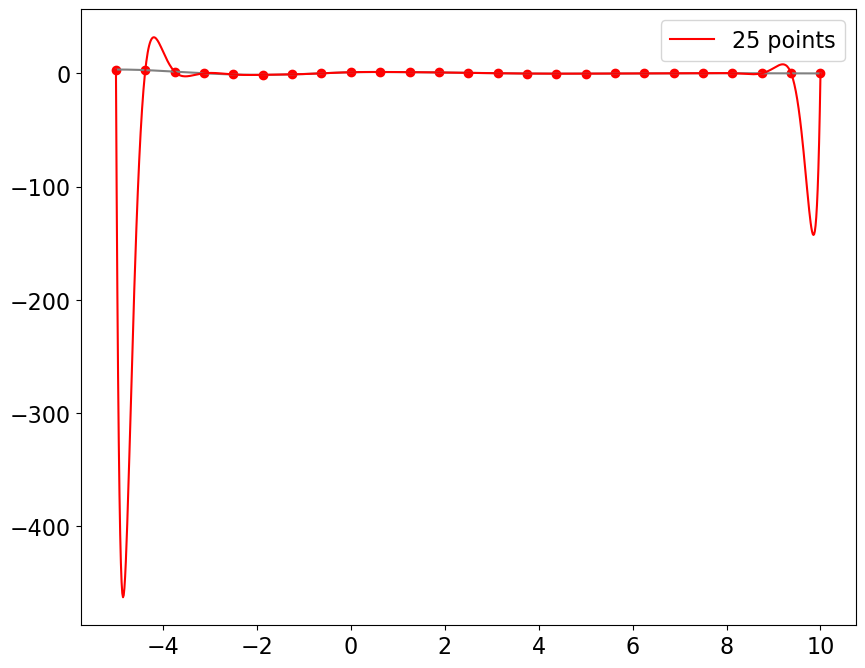

In [32]:
# how number of points affect the approximation (with degree=n-1)
for n, clr in (5,'m'),(10,'b'),(15,'g'),(25,'r'):
    x2 = np.linspace(-5,10,n)
    p = polynomial.polyfit(x2,func(x2),n-1)
    fi = lambda x: polynomial.polyval(x,p)
    plot1(fi,fdata=(x2,func(x2)),label='%d points'%n,color=clr,extrapolation=True)
    plt.show()

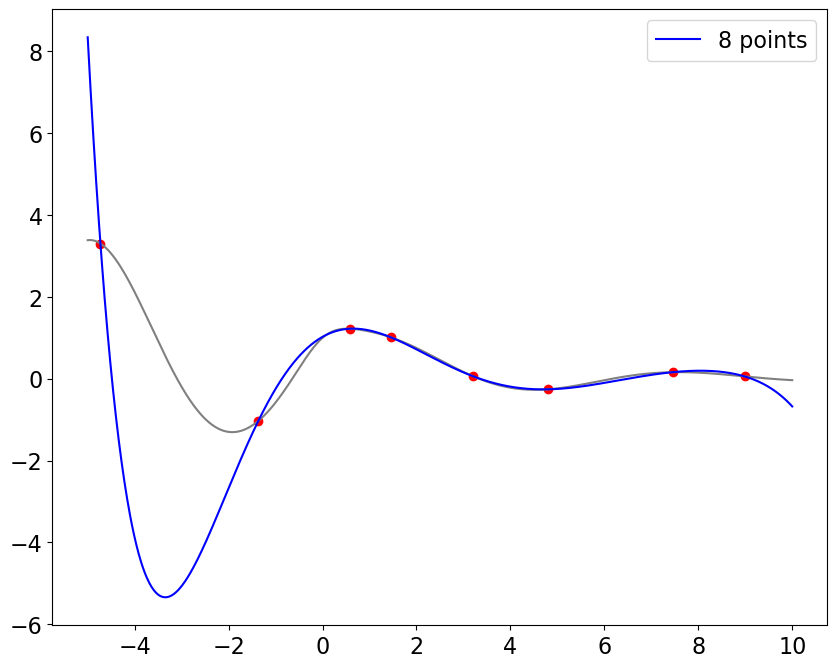

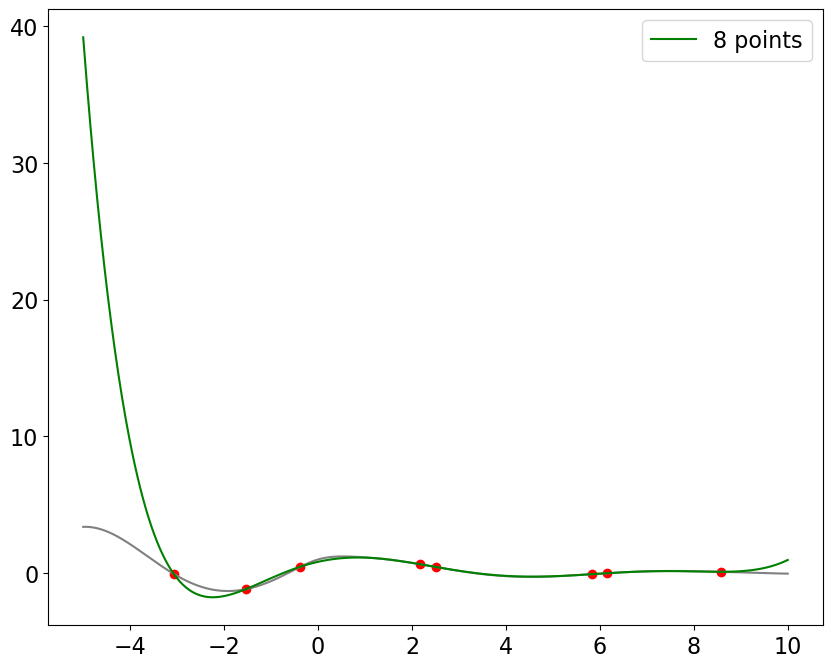

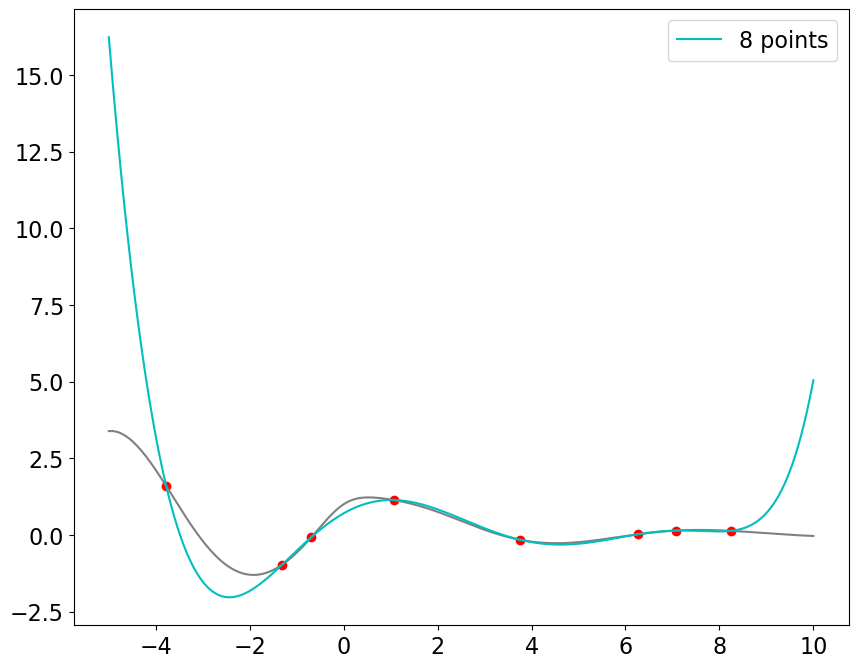

In [33]:
# how locations of points affect the approximation (with degree=n-1)
np.random.seed(2025)
n=8
for clr in 'b','g','c':
    x2 = np.linspace(-4,9,n) + np.random.uniform(-1,1,n) # perturb points a little
    p = polynomial.polyfit(x2,func(x2),n-1)
    fi = lambda x: polynomial.polyval(x,p)
    plot1(fi,fdata=(x2,func(x2)),label='%d points'%n,color=clr,extrapolation=True)
    plt.show()

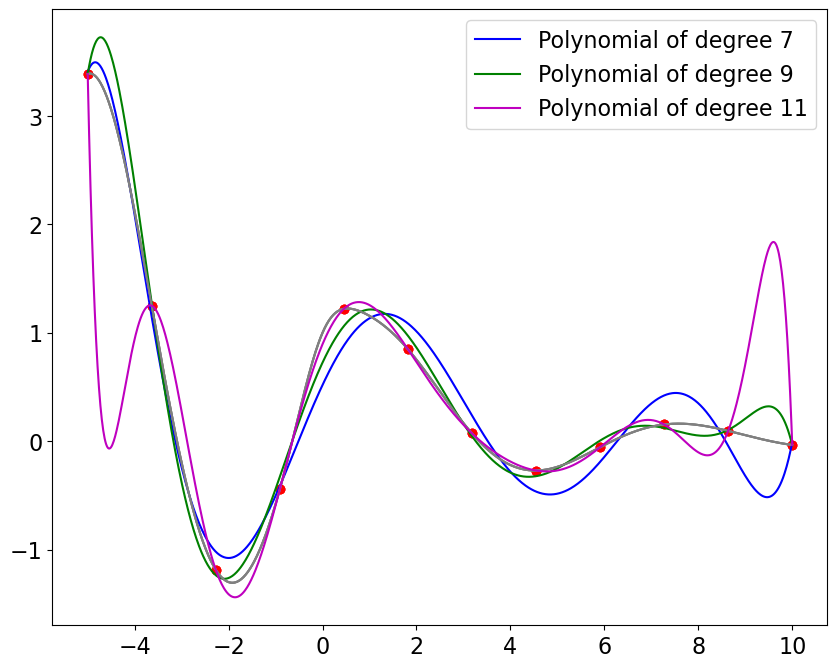

In [34]:
# how degree of the polynomial affects the approximation
for degree, clr in (7,'b'),(9,'g'),(11,'m'):
    p=polynomial.polyfit(xr,func(xr),degree)
    fi=lambda x: polynomial.polyval(x,p)
    plot1(fi,fdata=(xr,func(xr)),label='Polynomial of degree %d'%degree,color=clr,extrapolation=True)